### DataSciene Spring 2019 Now You "C" Me Group
link to video: https://youtu.be/lhodcPtmywc

# Schwann Cell Cyclic AMP Data Normalization

## Introduction to what I am doing here

This is going to be a copy of the ARPE-19 Data Normalization. I am going to keep all of the information about how I normalize the data and simply update the actual code for changes in file names, sample numbers, cutoff points, etc. This should mirror the ARPE_normalizing.RNA.and.hMeDIP.ipynb notebook very closely.

To start with, I have my raw count files. I have combined them already (using bash scripting), so it is in table format where it is tab delimited like this:

    Gene_ID | Sample 1 | Sample 2 | Sample 3 | Sample 4
    ENSRN0001 | 6 | 8 | 24| 29
    ENSRN0002 | 12 | 13 | 14 | 13
    ENSRN0003 | 18 | 17 | 1 | 0

For the RNA I also have results from edgeR and DESeq2. I have the transcript info from the GTF file in a csv file that I will use to determine transcript length.

For the hMeDIP samples I also have the edgeR statistical analysis, the bed file stating the location of the each peak (chromosome, start, stop, name of peak), the count data for genomic input (which was used for the peak calling and will be used for determining the cutoff of expression) and the region_analysis output which tells which gene the peak is close to. 

RNA-seq samples were aligned using STAR and then quantified using htseq-count. Both edgeR and DESeq2 are used for differential analysis and genes below a false discovery rate (FDR, also called adjusted P-value) of 0.05 by both DESeq2 and edgeR will be called differential. A limit of detection will be calculated using the genomic input from the hMeDIP-seq portion of the experiment. 

hMeDIP-seq peaks were called using the irreproducible discovery rate pipeline designed for the ChIP-seq portion of the ENCODE consortium. Counts were generated using htseq-count. Differential analysis was calculated using edgeR. To account for not having a second statistical program (DESeq2 can't normalize to all data), a cutoff of 1.5-fold change will be used in conjunction with an FDR of 0.05 by edgeR to determine differential peaks.

Genes that have more count data after treatment (increase in expression) or peaks that have higher count data (increase in enrichment from the antibody) are considered "Upregulated". Genes that have fewer counts or lower coverage (decreae in expression) or peaks that have lower coverage (decreased enrichment from the antibody) are considered "Downregulated". Genes that have relatively similar count data or that do not achieve statistical significant are considered "Nondifferential".




### hMeDIP-seq normalization 

In this particular jupyter notebook, I am going to be cleaning up the data. This has many steps, and I am going to save many intermediate files. Most of those files will not be used in the correlation or classification parts of this project, but the files are still useful for this project and may be used in future directions from this sampleset.

The first step to cleaning up the hMeDIP-seq data is to normalize the counts to the total number of reads. This is a Read Count Per Million (RCPM), but this first one does not exclude outliers. 

The next step is to determine which peaks are outliers. The reason for this is that outliers can bias your normalization. As an example, if you have two samples that are identical, and then you spike in DNA that will be in one region for 50% of one of the samples, your normalization will all be wrong. Instead of saying that your spiked-sample has one peak that is significantly different than what is found in the other sample, all of your peaks look like they have half as much coverage as the non-spiked sample and all regions appear differential. If you remove the one spiked region from the normalization, now the unchanged regions all appear the same between the samples (as they should), but the spiked in reads still appear only in the one sample. For this reason, this step includes a linear regression between the two sample types (in this case control and vitamin C), and then a Cook's value of 1 (can be changed), is used to determine the outliers. 

Once you have identified outliers, you can go back to the raw count data and normalize to total read counts excluding the outliers. This gives you the RCPM. This file is saved as the RCPM table.

The next step is to normalize to the RCPM by the width of each peak. This allows you to compare one peak to another. If you don't do this and you compare one peak that covers 100 base pairs (bp) to another peak that covers 100,000 bp, you would just by chance expect that the secon peak has 1,000 times as many reads. To normalize this, we take the RCPM and multiply by 1,000 and divide by the length of the peak. This is referred to as "Fragments Per Kilobase per Million mapped reads" (FPKM, see Trapnell et al. 2012, Nature Protocols). To do this, I use the peaks bed file, which contains information about the start and stop positions of each peak that can be used to calculate the length of each peak. This file is saved as the FPKM table. 

Once reads are normalized correctly, I incorporate the statistical data. For hMeDIP-seq, I use edgeR and a fold change. Peaks that receive a false-discovery rate (FDR, benjamini-hocherberg correction) below 0.05 and a fold change of 1.5x or greater are considered differential.

The next step is to determine which genes are most likely affected by each peak. To do this I used region_analysis, which is a program developed for the ENCODE project. This tells you which gene is closest to the center of the peak and how far the peak is from the transcription start site (TSS) of the gene. Using this data, I can assign each peak to a gene (or classify it as intergenic), and classify each to a region of the gene (upstream promoter, TSS, downstream promoter or gene body). 

There are a lot more peaks than genes, and most genes contain many peaks. As such, the next step is to determine the counts of peaks in each region per gene. Additionally, these peaks are divided by how they respond to vitamin C (upregulated, downregulated or nondifferential). This file is saved as a counts per gene region file. 


### Normalizing RNA-seq data

Like the hMeDIP-seq data, the RNA-seq data needs to be normalized. The first step is to normalize to the total reads within annotated features, and then to find outliers, just like is done for the hMeDIP-seq. You next go back to the raw count data and normalize to the total read counts within annotated features that are not outliers to get the RCPM table. Next, you use the genomic info file to get the lengths of each transcript and calculate the FPKM. This is essentially identical to the first few steps of hMeDIP-seq, except that we don't include reads that don't lie within annotated features for RNA. 

Next, we need to determine differential genes. For RNA-seq data, we use both edgeR and DESeq2. Genes that receive an FDR value below 0.05 by both edgeR and DESeq2 are considered differential. No fold change limit is taken into account and using two algorithms for differential analysis is thought to limit false positives. 

Again, the fold change is used to split differential genes into upregulated and downregulated genes.

Now, the counts of peaks per gene region are integrated with the RNA-seq data to generate a table that contains information that will be used for our classification analysis. Other information that is kept in the file includes gene biotype (e.g. protein coding, long noncoding RNA, antisense RNA, etc.) and the length of the gene. 

The next step is different than was used for hMeDIP-seq. For the hMeDIP-seq, I used the IDR pipeline (from ENCODE) to determine which regions were highly enriched. However, for RNA we look at all annotated regions. Most of these regions, however, are not going to have any reads. This step is determining which genes are above our limit of detection. To do this, I perform the normalization of the genomic input data. The genomic input data was generated for hMeDIP-seq, but has no enrichment. It is meant to represent what we would get if we sequenced just noise. For the RNA, I draw out density plots of the RNA-seq samples and the genomic input. If we use a limit of detection (LOD) below the highest expressed genomic input, then those are essentially false positives for the LOD. If we use a LOD above the bottom of the true genes, then those true genes below that point ar false negatives for our LOD. For this, I look at the density plot and take the point where the RNA-seq data overlaps the genomic input to find the minimum number of false positives and false negatives. Only the transcripts above the determined LOD are used for the rest of this project. 

#### Reading in the count files and normalizing them
The first step is going to be reading in the count files and normalizing them to total read counts. There will be multiple steps of normalization, but this is the first one.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.listdir("Input_Data/SC-cAMP_Dataset")


['SC_cAMP.hMeDIP.IP.samples.counts.txt',
 '.DS_Store',
 'SC.cAMP_RNA.counts.txt',
 'SC.cAMP_RNA.edgeR.csv',
 'SC.cAMP.hMeDIP.Region.analysis.bed.txt',
 'SC.cAMP.hMeDIP.edgeR.csv',
 'SC_cAMP.hMeDIP.Input.samples.counts.txt',
 'SC.cAMP.Merged.Final.Peaks.bed',
 'SC.cAMP_RNA.DESeq2.csv']

In [3]:
os.listdir("Input_Data/")

['MM10.Consensus.Transcript.Info.csv',
 '.DS_Store',
 'SC-cAMP_Dataset',
 'HG38.90.Consensus.transcript.info.csv',
 'RN6.91.Consensus.transcript.info.csv',
 'ARPE-19_Dataset',
 'SC-VitC_Dataset']

In [4]:
os.getcwd()

'/Users/david/Documents/David_Sant/Classes/Data_Science_COMP_5360/2019-datascience-homeworks/Final Project/now-u-c-me-datascience-final-project'

In [5]:
Input_path = r"Input_Data/SC-cAMP_Dataset/"
Output_Path = r"Output_Tables_and_Results/SC-cAMP_Intermediate_Files/"

Input_hMeDIP_Counts_File = Input_path+"SC_cAMP.hMeDIP.IP.samples.counts.txt"
Input_hMeDIP_edgeR = Input_path+"SC.cAMP.hMeDIP.edgeR.csv"
Input_region_analysis = Input_path+"SC.cAMP.hMeDIP.Region.analysis.bed.txt"
Input_Genomic_Input_Counts_File = Input_path+"SC_cAMP.hMeDIP.Input.samples.counts.txt"
Input_bed_file = Input_path+"SC.cAMP.Merged.Final.Peaks.bed"

Input_RNA_Counts_File = Input_path+"SC.cAMP_RNA.counts.txt"
Input_RNA_edgeR = Input_path+"SC.cAMP_RNA.edgeR.csv"
Input_RNA_DESeq2 = Input_path+"SC.cAMP_RNA.DESeq2.csv"

Input_genomic_info_file = "Input_Data/RN6.91.Consensus.transcript.info.csv"

In [6]:
SC_cAMP_hMeDIP_raw = pd.read_csv(Input_hMeDIP_Counts_File, sep = "\t", index_col = 0)

In [7]:
print(len(SC_cAMP_hMeDIP_raw))
SC_cAMP_hMeDIP_raw.head()

192148


,SC_Control_1_IP,SC_Control_2_IP,SC_Control_3_IP,SC_cAMP_1_IP,SC_cAMP_2_IP,SC_cAMP_3_IP
Peak_Name,,,,,,
Merged.cAMP_peak_100,79,100,61,113,192,202
Merged.cAMP_peak_10000,56,73,50,188,212,299
Merged.cAMP_peak_100003,60,75,60,178,255,278
Merged.cAMP_peak_100004,27,37,24,52,77,91
Merged.cAMP_peak_100007,43,34,29,69,112,125


In [8]:
# Dave notes, axis = 0 means column wise; axis = 1 means row wise
# so a sum of axis=0 means the counts for the entire column
total_counts_SC_cAMP_hMeDIP_Raw = SC_cAMP_hMeDIP_raw.sum(axis=0)

In [9]:
total_counts_SC_cAMP_hMeDIP_Raw

SC_Control_1_IP    64089453
SC_Control_2_IP    68587373
SC_Control_3_IP    63471316
SC_cAMP_1_IP       70960680
SC_cAMP_2_IP       64751750
SC_cAMP_3_IP       78618595
dtype: int64

In [10]:
total_counts_SC_cAMP_hMeDIP_Raw[0]

64089453

In [11]:
SC_cAMP_hMeDIP_raw["SC_cAMP_Control_1_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_Control_1_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[0]
SC_cAMP_hMeDIP_raw["SC_cAMP_Control_2_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_Control_2_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[1]
SC_cAMP_hMeDIP_raw["SC_cAMP_Control_3_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_Control_3_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[2]

SC_cAMP_hMeDIP_raw["SC_cAMP_cAMP_1_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_cAMP_1_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[3]
SC_cAMP_hMeDIP_raw["SC_cAMP_cAMP_2_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_cAMP_2_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[4]
SC_cAMP_hMeDIP_raw["SC_cAMP_cAMP_3_IP_First_RCPM"] = SC_cAMP_hMeDIP_raw["SC_cAMP_3_IP"]*1000000/total_counts_SC_cAMP_hMeDIP_Raw[5]


In [12]:
SC_cAMP_hMeDIP_raw["Control_Average"] = SC_cAMP_hMeDIP_raw[["SC_cAMP_Control_1_IP_First_RCPM","SC_cAMP_Control_2_IP_First_RCPM", "SC_cAMP_Control_3_IP_First_RCPM"]].mean(axis=1)
SC_cAMP_hMeDIP_raw["cAMP_Average"] = SC_cAMP_hMeDIP_raw[["SC_cAMP_cAMP_1_IP_First_RCPM","SC_cAMP_cAMP_2_IP_First_RCPM", "SC_cAMP_cAMP_3_IP_First_RCPM"]].mean(axis=1)


In [13]:
SC_cAMP_hMeDIP_raw.head()


,SC_Control_1_IP,SC_Control_2_IP,SC_Control_3_IP,SC_cAMP_1_IP,SC_cAMP_2_IP,SC_cAMP_3_IP,SC_cAMP_Control_1_IP_First_RCPM,SC_cAMP_Control_2_IP_First_RCPM,SC_cAMP_Control_3_IP_First_RCPM,SC_cAMP_cAMP_1_IP_First_RCPM,SC_cAMP_cAMP_2_IP_First_RCPM,SC_cAMP_cAMP_3_IP_First_RCPM,Control_Average,cAMP_Average
Peak_Name,,,,,,,,,,,,,,
Merged.cAMP_peak_100,79,100,61,113,192,202,1.232652,1.457994,0.961064,1.592431,2.965171,2.569367,1.217237,2.375656
Merged.cAMP_peak_10000,56,73,50,188,212,299,0.873779,1.064336,0.787757,2.649355,3.274043,3.803172,0.908624,3.242190
Merged.cAMP_peak_100003,60,75,60,178,255,278,0.936191,1.093496,0.945309,2.508431,3.938118,3.536059,0.991665,3.327536
Merged.cAMP_peak_100004,27,37,24,52,77,91,0.421286,0.539458,0.378124,0.732800,1.189157,1.157487,0.446289,1.026481
Merged.cAMP_peak_100007,43,34,29,69,112,125,0.670937,0.495718,0.456899,0.972369,1.729683,1.589955,0.541185,1.430669


In [14]:
# Dave Notes
# The sum of the FPKM columns is always going to be 1,000,000 (when I include all rows) because that is how I normalized it
# 1M/215956 gives the 4.630573 average

SC_cAMP_hMeDIP_raw[["Control_Average","cAMP_Average" ]].describe()

,Control_Average,cAMP_Average
count,192148.000000,192148.000000
mean,5.204322,5.204322
std,1711.170964,1510.651646
min,0.000000,0.000000
25%,0.689618,0.818987
50%,1.085995,1.313062
75%,1.642825,2.183447
max,750087.644574,662190.896958


In [15]:
SC_cAMP_hMeDIP_raw.sum(axis=0) # should be 1M for all normalized columns

SC_Control_1_IP                    64089453.0
SC_Control_2_IP                    68587373.0
SC_Control_3_IP                    63471316.0
SC_cAMP_1_IP                       70960680.0
SC_cAMP_2_IP                       64751750.0
SC_cAMP_3_IP                       78618595.0
SC_cAMP_Control_1_IP_First_RCPM     1000000.0
SC_cAMP_Control_2_IP_First_RCPM     1000000.0
SC_cAMP_Control_3_IP_First_RCPM     1000000.0
SC_cAMP_cAMP_1_IP_First_RCPM        1000000.0
SC_cAMP_cAMP_2_IP_First_RCPM        1000000.0
SC_cAMP_cAMP_3_IP_First_RCPM        1000000.0
Control_Average                     1000000.0
cAMP_Average                        1000000.0
dtype: float64

Now I have read in the hMeDIP count files and done the first normalization, a read count per million (RCPM). This does not take out any outliers, nor does it take out any of the columns that are added by htseq-count that are reads not within annotated features. Notice that the RCPM files all add up to 1,000,000 which is why this is read counts per million. 

The next step will be to determine if there are any outliers that should be taken out of the normalization. I will determine outliers without the htseq columns, but they will be added back in for the final RCPM normalization. For this step, I run a linear regression of the averages per treatment type (vitamin C and control). I look for a cook's cutoff value (usually a value of 1 is used), and then I remove those points that have a high cooks value for the normalization. 

In [16]:
columns_added_by_htseq = ["__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__not_aligned", "__alignment_not_unique"]

In [17]:
SC_cAMP_hMeDIP_first_RCPM_averages = SC_cAMP_hMeDIP_raw[["Control_Average","cAMP_Average" ]].drop(columns_added_by_htseq, axis = 0)

In [18]:
len(SC_cAMP_hMeDIP_first_RCPM_averages)

192143

In [19]:
SC_cAMP_hMeDIP_first_RCPM_averages.tail()

,Control_Average,cAMP_Average
Peak_Name,,
Merged.control_peak_99972,1.447705,1.067706
Merged.control_peak_99982,1.202852,0.772719
"Merged.control_peak_99992,Merged.cAMP_peak_89678",3.019866,1.849421
Merged.control_peak_99996,0.980222,0.541028
Merged.control_peak_99997,1.631965,0.729319


In [20]:
SC_cAMP_hMeDIP_first_RCPM_averages.describe()

,Control_Average,cAMP_Average
count,192143.000000,192143.000000
mean,1.300629,1.758084
std,1.023074,1.482280
min,0.004860,0.111344
25%,0.689622,0.819021
50%,1.085997,1.313069
75%,1.642792,2.183432
max,51.202739,75.666215


It looks like the mean for vitamin C is slightly higher, but that is not too surprising because vitamin C leads to a global increase in 5hmC. However, the minimum is lower in the vitamin C treated. I have seen this in all the other datasets too.

Now I have to make a linear regression using the averages and figure out which ones are outliers.
<br>I will not graph it using the ones that start with "_" because they need to be included in normalization because it is immunoprecipitation and this makes it include reads not within peaks.
<br>I am choosing to use cook's cutoff to determine outliers because it takes both X and Y axes into consideration, and it is used by DESeq2 for their normalization. Additionally, it calculates a P-value giving an easier time to determining a cutoff and it runs quickly. I am going to exclude points where Cook's distance > 1 because this looks correct in the graph and this is the default for DESeq2.   


In [21]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm
import statsmodels as stats

import matplotlib.pyplot as plt 
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [22]:
from statsmodels.stats import outliers_influence
import statsmodels.stats

In [23]:
SC_cAMP_hMeDIP_first_RCPM_averages.to_csv("camp.first.linear.csv")

In [24]:

linear_model = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_hMeDIP_first_RCPM_averages).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                 4.293e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:18:51   Log-Likelihood:            -3.2889e+05
No. Observations:              192143   AIC:                         6.578e+05
Df Residuals:                  192141   BIC:                         6.578e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9528      0.005    192.673      0.000       0.943       0.962
Control_Average     0.6192      0.003    207.203      0.000       0.613       0.625
==============================================================================
Omnibus:                   158820.484   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20692293.145
Skew:                           3.323   Prob(JB):                         0.00
Kurtosis:                      53.403   Cond. No.                         3.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
influence = linear_model.get_influence()
(cook,p_cook) = influence.cooks_distance
SC_cAMP_hMeDIP_first_RCPM_averages["Cook_Value"] = cook
SC_cAMP_hMeDIP_first_RCPM_averages["Cook_P_Value"] = p_cook

In [26]:
SC_cAMP_hMeDIP_first_RCPM_averages.tail()

,Control_Average,cAMP_Average,Cook_Value,Cook_P_Value
Peak_Name,,,,
Merged.control_peak_99972,1.447705,1.067706,9.031298e-07,0.999999
Merged.control_peak_99982,1.202852,0.772719,1.250655e-06,0.999999
"Merged.control_peak_99992,Merged.cAMP_peak_89678",3.019866,1.849421,5.247871e-06,0.999995
Merged.control_peak_99996,0.980222,0.541028,1.651089e-06,0.999998
Merged.control_peak_99997,1.631965,0.729319,2.437612e-06,0.999998


In [27]:
SC_cAMP_hMeDIP_removing_outliers = SC_cAMP_hMeDIP_first_RCPM_averages[SC_cAMP_hMeDIP_first_RCPM_averages.Cook_Value <= 1]
SC_cAMP_hMeDIP_outliers = SC_cAMP_hMeDIP_first_RCPM_averages[SC_cAMP_hMeDIP_first_RCPM_averages.Cook_Value > 1]

In [28]:
print(len(SC_cAMP_hMeDIP_first_RCPM_averages))
print(len(SC_cAMP_hMeDIP_removing_outliers))
print(len(SC_cAMP_hMeDIP_outliers))

192143
192143
0


In [29]:
SC_cAMP_hMeDIP_outliers

,Control_Average,cAMP_Average,Cook_Value,Cook_P_Value
Peak_Name,,,,


Wow. There wasn't a single outlier in this one. I will still have to see what it graphs like. 

In [30]:
outliers_removed_model = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_hMeDIP_removing_outliers).fit()
outliers_removed_model.summary()
# Same R-2 value, but there was only one outlier

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                 4.293e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:18:52   Log-Likelihood:            -3.2889e+05
No. Observations:              192143   AIC:                         6.578e+05
Df Residuals:                  192141   BIC:                         6.578e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9528      0.005    192.673      0.000       0.943       0.962
Control_Average     0.6192      0.003    207.203      0.000       0.613       0.625
==============================================================================
Omnibus:                   158820.484   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20692293.145
Skew:                           3.323   Prob(JB):                         0.00
Kurtosis:                      53.403   Cond. No.                         3.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the statsmodels website: http://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.summary_frame.html
<br>cooks_d : Cook’s Distance defined in Influence.cooks_distance
<br>standard_resid : Standardized residuals defined in Influence.resid_studentized_internal
<br>hat_diag : The diagonal of the projection, or hat, matrix defined in Influence.hat_matrix_diag
<br>dffits_internal : DFFITS statistics using internally Studentized residuals defined in Influence.dffits_internal
<br>dffits : DFFITS statistics using externally Studentized residuals defined in Influence.dffits
<br>student_resid : Externally Studentized residuals defined in Influence.resid_studentized_external

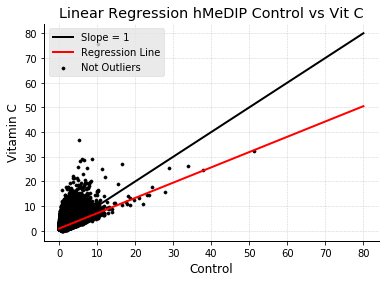

In [31]:
#outliers = ARPE_hMeDIP_outliers["cAMP_Average"].values
fig, tmp = plt.subplots()
ax = SC_cAMP_hMeDIP_first_RCPM_averages.plot.scatter(y = "cAMP_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
#ax.scatter(y = SC_cAMP_hMeDIP_outliers["cAMP_Average"], x = SC_cAMP_hMeDIP_outliers["Control_Average"], 
           #color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 80, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression hMeDIP Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model.params
x = sc.linspace(0, 80, 10)
y = parameters[0] + parameters[1]*x

#outliers_removed_model
#outlier_parameters = outliers_removed_model.params
#x = sc.linspace(0, 350, 10)
#outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
#plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_cAMP_hMeDIP_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()
#plt.savefig(Output_Path+"ARPE_hMeDIP_Finding_Outliers.png")

Wow! This looks awful. I am going to try to change the cutoff and see if I can make it make more sense. 

In [32]:
SC_cAMP_hMeDIP_removing_outliers = SC_cAMP_hMeDIP_first_RCPM_averages[SC_cAMP_hMeDIP_first_RCPM_averages.Cook_Value <= 0.001]
SC_cAMP_hMeDIP_outliers = SC_cAMP_hMeDIP_first_RCPM_averages[SC_cAMP_hMeDIP_first_RCPM_averages.Cook_Value > 0.001]
print(len(SC_cAMP_hMeDIP_first_RCPM_averages))
print(len(SC_cAMP_hMeDIP_removing_outliers))
print(len(SC_cAMP_hMeDIP_outliers))

192143
191922
221


In [33]:
outliers_removed_model = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_hMeDIP_removing_outliers).fit()
outliers_removed_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                 3.677e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:18:54   Log-Likelihood:            -3.2013e+05
No. Observations:              191922   AIC:                         6.403e+05
Df Residuals:                  191920   BIC:                         6.403e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0133      0.005    211.046      0.000       1.004       1.023
Control_Average     0.5638      0.003    191.744      0.000       0.558       0.570
==============================================================================
Omnibus:                    93631.617   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           683173.793
Skew:                           2.246   Prob(JB):                         0.00
Kurtosis:                      11.078   Cond. No.                         3.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

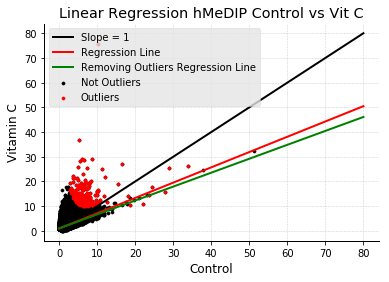

In [34]:
#outliers = ARPE_hMeDIP_outliers["cAMP_Average"].values
fig, tmp = plt.subplots()
ax = SC_cAMP_hMeDIP_first_RCPM_averages.plot.scatter(y = "cAMP_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = SC_cAMP_hMeDIP_outliers["cAMP_Average"], x = SC_cAMP_hMeDIP_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 80, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression hMeDIP Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model.params
x = sc.linspace(0, 80, 10)
y = parameters[0] + parameters[1]*x

#outliers_removed_model
outlier_parameters = outliers_removed_model.params
x = sc.linspace(0, 80, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_cAMP_hMeDIP_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()


Wow. This changes almost nothing. I am just going to include everything for the normalization and run it as though there are no outliers. 

In [35]:
# remove_outliers = SC_cAMP_hMeDIP_raw.drop(SC_cAMP_hMeDIP_outliers.index, axis = 0)
# total_counts_removing_outliers = remove_outliers.sum(axis=0)

In [36]:
# total_counts_removing_outliers

In [37]:
# LAA means Vitamin C. I am changing the name out for cAMP because more people will recognize it
# SC_cAMP_hMeDIP_raw["Control_1_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_Control_1_IP"]*1000000/total_counts_removing_outliers[0]
# SC_cAMP_hMeDIP_raw["Control_2_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_Control_2_IP"]*1000000/total_counts_removing_outliers[1]
# SC_cAMP_hMeDIP_raw["Control_3_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_Control_3_IP"]*1000000/total_counts_removing_outliers[2]

# SC_cAMP_hMeDIP_raw["cAMP_1_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_cAMP_1_IP"]*1000000/total_counts_removing_outliers[3]
# SC_cAMP_hMeDIP_raw["cAMP_2_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_cAMP_2_IP"]*1000000/total_counts_removing_outliers[4]
# SC_cAMP_hMeDIP_raw["cAMP_3_Corrected_RCPM"]= SC_cAMP_hMeDIP_raw["SC_cAMP_3_IP"]*1000000/total_counts_removing_outliers[5]


In [38]:
#SC_cAMP_hMeDIP_Corrected_RCPM = SC_cAMP_hMeDIP_raw[["Control_1_Corrected_RCPM", "Control_2_Corrected_RCPM", "Control_3_Corrected_RCPM", "cAMP_1_Corrected_RCPM", "cAMP_2_Corrected_RCPM", "cAMP_3_Corrected_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [39]:
#len(SC_cAMP_hMeDIP_Corrected_RCPM)

In [40]:
#SC_cAMP_hMeDIP_Corrected_RCPM.head()

In [41]:
# samples = ["SC_Control_1_hMeDIP_RCPM", "SC_Control_2_hMeDIP_RCPM", "SC_Control_3_hMeDIP_RCPM",
#            "SC_cAMP_1_hMeDIP_RCPM", "SC_cAMP_2_hMeDIP_RCPM", "SC_cAMP_3_hMeDIP_RCPM"]

# SC_cAMP_hMeDIP_Corrected_RCPM.columns= samples


In [42]:
#SC_cAMP_hMeDIP_Corrected_RCPM.head()

In [43]:
SC_cAMP_hMeDIP_raw.head()

,SC_Control_1_IP,SC_Control_2_IP,SC_Control_3_IP,SC_cAMP_1_IP,SC_cAMP_2_IP,SC_cAMP_3_IP,SC_cAMP_Control_1_IP_First_RCPM,SC_cAMP_Control_2_IP_First_RCPM,SC_cAMP_Control_3_IP_First_RCPM,SC_cAMP_cAMP_1_IP_First_RCPM,SC_cAMP_cAMP_2_IP_First_RCPM,SC_cAMP_cAMP_3_IP_First_RCPM,Control_Average,cAMP_Average
Peak_Name,,,,,,,,,,,,,,
Merged.cAMP_peak_100,79,100,61,113,192,202,1.232652,1.457994,0.961064,1.592431,2.965171,2.569367,1.217237,2.375656
Merged.cAMP_peak_10000,56,73,50,188,212,299,0.873779,1.064336,0.787757,2.649355,3.274043,3.803172,0.908624,3.242190
Merged.cAMP_peak_100003,60,75,60,178,255,278,0.936191,1.093496,0.945309,2.508431,3.938118,3.536059,0.991665,3.327536
Merged.cAMP_peak_100004,27,37,24,52,77,91,0.421286,0.539458,0.378124,0.732800,1.189157,1.157487,0.446289,1.026481
Merged.cAMP_peak_100007,43,34,29,69,112,125,0.670937,0.495718,0.456899,0.972369,1.729683,1.589955,0.541185,1.430669


In [44]:
SC_cAMP_hMeDIP_RCPM_Table = SC_cAMP_hMeDIP_raw[["SC_cAMP_Control_1_IP_First_RCPM", "SC_cAMP_Control_2_IP_First_RCPM", "SC_cAMP_Control_3_IP_First_RCPM",
                  "SC_cAMP_cAMP_1_IP_First_RCPM", "SC_cAMP_cAMP_2_IP_First_RCPM", "SC_cAMP_cAMP_3_IP_First_RCPM"]]
SC_cAMP_hMeDIP_RCPM_Table.columns = ("SC_Control_1_IP_RCPM", "SC_Control_2_IP_RCPM", "SC_Control_3_IP_RCPM",
                                    "SC_cAMP_1_IP_RCPM", "SC_cAMP_2_IP_RCPM", "SC_cAMP_3_IP_RCPM")
SC_cAMP_hMeDIP_RCPM_Table = SC_cAMP_hMeDIP_RCPM_Table.drop(columns_added_by_htseq, axis = 0)

In [45]:
SC_cAMP_hMeDIP_RCPM_Table.head()

,SC_Control_1_IP_RCPM,SC_Control_2_IP_RCPM,SC_Control_3_IP_RCPM,SC_cAMP_1_IP_RCPM,SC_cAMP_2_IP_RCPM,SC_cAMP_3_IP_RCPM
Peak_Name,,,,,,
Merged.cAMP_peak_100,1.232652,1.457994,0.961064,1.592431,2.965171,2.569367
Merged.cAMP_peak_10000,0.873779,1.064336,0.787757,2.649355,3.274043,3.803172
Merged.cAMP_peak_100003,0.936191,1.093496,0.945309,2.508431,3.938118,3.536059
Merged.cAMP_peak_100004,0.421286,0.539458,0.378124,0.732800,1.189157,1.157487
Merged.cAMP_peak_100007,0.670937,0.495718,0.456899,0.972369,1.729683,1.589955


In [46]:
SC_cAMP_hMeDIP_RCPM_Table.to_csv(Output_Path+"SC_cAMP_hMeDIP_RCPM_table.csv")

Now I officially have excluded outliers from the normalization and made the read counts per million. The next step is to divide by length and multiply by 1000 to get "Fragments per Kilobase per Million", also known as FPKM. 
I have the bed file that has the info about peak length for this.

In [47]:
#SC_cAMP_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3, names=["Chromosome", "Start", "Stop", "Peak_Name"], dtype = {"Chromosome" : 'str', "Start" : 'int', "Stop" : 'int', "Peak_Name" : 'str'})
SC_cAMP_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3)



In [48]:
SC_cAMP_hMeDIP_bed.head()

,Chr,Start,Stop
Peak_Name,,,
Merged.cAMP_peak_100,1,1967917,1968676
Merged.cAMP_peak_10000,1,56166555,56167312
Merged.cAMP_peak_100003,13,50411889,50412871
Merged.cAMP_peak_100004,13,50421254,50421647
Merged.cAMP_peak_100007,13,50424220,50424677


In [49]:
print(len(SC_cAMP_hMeDIP_bed))
len(SC_cAMP_hMeDIP_RCPM_Table)

192143


192143

In [50]:
SC_cAMP_hMeDIP_bed.dtypes

Chr      object
Start     int64
Stop      int64
dtype: object

In [51]:
SC_cAMP_hMeDIP_bed["Width"] = (SC_cAMP_hMeDIP_bed["Stop"] - SC_cAMP_hMeDIP_bed["Start"] + 1)

In [52]:
SC_cAMP_hMeDIP_bed.head()

,Chr,Start,Stop,Width
Peak_Name,,,,
Merged.cAMP_peak_100,1,1967917,1968676,760
Merged.cAMP_peak_10000,1,56166555,56167312,758
Merged.cAMP_peak_100003,13,50411889,50412871,983
Merged.cAMP_peak_100004,13,50421254,50421647,394
Merged.cAMP_peak_100007,13,50424220,50424677,458


In [53]:
SC_cAMP_hMeDIP_RCPM_Table = SC_cAMP_hMeDIP_RCPM_Table.join(SC_cAMP_hMeDIP_bed)

In [54]:
SC_cAMP_hMeDIP_RCPM_Table.head()

,SC_Control_1_IP_RCPM,SC_Control_2_IP_RCPM,SC_Control_3_IP_RCPM,SC_cAMP_1_IP_RCPM,SC_cAMP_2_IP_RCPM,SC_cAMP_3_IP_RCPM,Chr,Start,Stop,Width
Peak_Name,,,,,,,,,,
Merged.cAMP_peak_100,1.232652,1.457994,0.961064,1.592431,2.965171,2.569367,1,1967917,1968676,760
Merged.cAMP_peak_10000,0.873779,1.064336,0.787757,2.649355,3.274043,3.803172,1,56166555,56167312,758
Merged.cAMP_peak_100003,0.936191,1.093496,0.945309,2.508431,3.938118,3.536059,13,50411889,50412871,983
Merged.cAMP_peak_100004,0.421286,0.539458,0.378124,0.732800,1.189157,1.157487,13,50421254,50421647,394
Merged.cAMP_peak_100007,0.670937,0.495718,0.456899,0.972369,1.729683,1.589955,13,50424220,50424677,458


In [55]:
SC_cAMP_hMeDIP_RCPM_Table["SC_Control_1_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_Control_1_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]
SC_cAMP_hMeDIP_RCPM_Table["SC_Control_2_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_Control_2_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]
SC_cAMP_hMeDIP_RCPM_Table["SC_Control_3_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_Control_3_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]

SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_1_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_1_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]
SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_2_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_2_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]
SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_3_FPKM"]= SC_cAMP_hMeDIP_RCPM_Table["SC_cAMP_3_IP_RCPM"]*1000/SC_cAMP_hMeDIP_RCPM_Table["Width"]


In [56]:
SC_cAMP_hMeDIP_RCPM_Table.head()

,SC_Control_1_IP_RCPM,SC_Control_2_IP_RCPM,SC_Control_3_IP_RCPM,SC_cAMP_1_IP_RCPM,SC_cAMP_2_IP_RCPM,SC_cAMP_3_IP_RCPM,Chr,Start,Stop,Width,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM
Peak_Name,,,,,,,,,,,,,,,,
Merged.cAMP_peak_100,1.232652,1.457994,0.961064,1.592431,2.965171,2.569367,1,1967917,1968676,760,1.621911,1.918414,1.264558,2.095304,3.901541,3.380746
Merged.cAMP_peak_10000,0.873779,1.064336,0.787757,2.649355,3.274043,3.803172,1,56166555,56167312,758,1.152742,1.404137,1.039258,3.495191,4.319318,5.017377
Merged.cAMP_peak_100003,0.936191,1.093496,0.945309,2.508431,3.938118,3.536059,13,50411889,50412871,983,0.952382,1.112407,0.961657,2.551812,4.006223,3.597212
Merged.cAMP_peak_100004,0.421286,0.539458,0.378124,0.732800,1.189157,1.157487,13,50421254,50421647,394,1.069254,1.369182,0.959704,1.859899,3.018165,2.937784
Merged.cAMP_peak_100007,0.670937,0.495718,0.456899,0.972369,1.729683,1.589955,13,50424220,50424677,458,1.464928,1.082354,0.997597,2.123077,3.776600,3.471517


In [57]:
SC_cAMP_hMeDIP_FPKM_table = SC_cAMP_hMeDIP_RCPM_Table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM", 
                                                        "SC_cAMP_1_FPKM", "SC_cAMP_2_FPKM", "SC_cAMP_3_FPKM"]]

In [58]:
SC_cAMP_hMeDIP_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM
Peak_Name,,,,,,
Merged.cAMP_peak_100,1.621911,1.918414,1.264558,2.095304,3.901541,3.380746
Merged.cAMP_peak_10000,1.152742,1.404137,1.039258,3.495191,4.319318,5.017377
Merged.cAMP_peak_100003,0.952382,1.112407,0.961657,2.551812,4.006223,3.597212
Merged.cAMP_peak_100004,1.069254,1.369182,0.959704,1.859899,3.018165,2.937784
Merged.cAMP_peak_100007,1.464928,1.082354,0.997597,2.123077,3.776600,3.471517


In [59]:
SC_cAMP_hMeDIP_FPKM_table.to_csv(Output_Path+"SC_cAMP_hMeDIP_FPKM_table.csv")
SC_cAMP_hMeDIP_FPKM_table.to_pickle(Output_Path+"SC_cAMP_hMeDIP_FPKM_table.pkl")

Now I have the FPKM values calculated correctly. Next I need to figure out which ones go up, which ones go down, and which ones don't change. I am going to use a fold change cutoff of 1.5X and a corrected P-value from edgeR cutoff of 0.05. 

In [60]:
SC_cAMP_hMeDIP_FPKM_table = pd.read_pickle(Output_Path+"SC_cAMP_hMeDIP_FPKM_table.pkl")

In [61]:
SC_cAMP_hMeDIP_FPKM_table["Control_Average_FPKM"] = SC_cAMP_hMeDIP_FPKM_table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM"]].mean(axis=1)
SC_cAMP_hMeDIP_FPKM_table["cAMP_Average_FPKM"] = SC_cAMP_hMeDIP_FPKM_table[["SC_cAMP_1_FPKM", "SC_cAMP_2_FPKM", "SC_cAMP_3_FPKM"]].mean(axis=1)
SC_cAMP_hMeDIP_FPKM_table["Fold_Change"] =  (SC_cAMP_hMeDIP_FPKM_table["cAMP_Average_FPKM"])/(SC_cAMP_hMeDIP_FPKM_table["Control_Average_FPKM"])
SC_cAMP_hMeDIP_FPKM_table["Log2FC"] = np.log2(SC_cAMP_hMeDIP_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

In [62]:
SC_cAMP_hMeDIP_FPKM_table.tail()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC
Peak_Name,,,,,,,,,,
Merged.control_peak_99972,2.856922,2.933590,2.948146,1.871414,2.858775,1.714720,2.912886,2.148303,0.737517,-0.439252
Merged.control_peak_99982,2.668479,2.909062,2.993852,1.807565,1.614058,2.084691,2.857131,1.835438,0.642406,-0.638443
"Merged.control_peak_99992,Merged.cAMP_peak_89678",4.573349,3.848022,3.594013,2.523159,2.355456,2.479823,4.005128,2.452813,0.612418,-0.707411
Merged.control_peak_99996,3.457771,1.938607,2.749513,1.873770,1.283401,1.338909,2.715297,1.498694,0.551945,-0.857405
Merged.control_peak_99997,3.091743,3.698986,2.275744,1.852878,1.115371,1.083525,3.022158,1.350591,0.446896,-1.161988


In [63]:
SC_cAMP_hMeDIP_edgeR = pd.read_csv(Input_hMeDIP_edgeR, sep = ",", index_col=0)


In [64]:
SC_cAMP_hMeDIP_edgeR.head()

,logFC,logCPM,LR,PValue,FDR
Peak_Name,,,,,
Merged.cAMP_peak_182075,-4.623746,3.129310,408.342747,8.410000e-91,1.620000e-85
Merged.cAMP_peak_82618,-4.470933,2.108313,360.272041,2.460000e-80,2.360000e-75
Merged.cAMP_peak_336317,-4.045135,2.217228,332.046820,3.440000e-74,2.210000e-69
Merged.cAMP_peak_12210,-4.775163,1.878797,314.271840,2.560000e-70,1.230000e-65
Merged.cAMP_peak_101018,-4.450692,2.092771,311.023947,1.310000e-69,5.020000e-65


In [65]:
SC_cAMP_hMeDIP_FPKM_table = SC_cAMP_hMeDIP_FPKM_table.join(SC_cAMP_hMeDIP_edgeR)

In [66]:
SC_cAMP_hMeDIP_FPKM_table.tail()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC,logFC,logCPM,LR,PValue,FDR
Peak_Name,,,,,,,,,,,,,,,
Merged.control_peak_99972,2.856922,2.933590,2.948146,1.871414,2.858775,1.714720,2.912886,2.148303,0.737517,-0.439252,0.445892,0.359352,3.290056,0.069701,0.084844
Merged.control_peak_99982,2.668479,2.909062,2.993852,1.807565,1.614058,2.084691,2.857131,1.835438,0.642406,-0.638443,0.632302,0.021963,7.232948,0.007158,0.011322
"Merged.control_peak_99992,Merged.cAMP_peak_89678",4.573349,3.848022,3.594013,2.523159,2.355456,2.479823,4.005128,2.452813,0.612418,-0.707411,0.706096,1.298915,13.078163,0.000299,0.000689
Merged.control_peak_99996,3.457771,1.938607,2.749513,1.873770,1.283401,1.338909,2.715297,1.498694,0.551945,-0.857405,0.852419,-0.348089,7.893768,0.004961,0.008223
Merged.control_peak_99997,3.091743,3.698986,2.275744,1.852878,1.115371,1.083525,3.022158,1.350591,0.446896,-1.161988,1.162051,0.270407,17.064577,0.000036,0.000099


In [67]:
SC_cAMP_hMeDIP_FPKM_table = SC_cAMP_hMeDIP_FPKM_table.drop(["logFC", "logCPM", "LR", "PValue"], axis = 1)

In [68]:
def direction(row):
    if row["FDR"] < 0.05 :
        if row["Log2FC"] >= 0.584962500721156:
            return "Upregulated"
        elif row["Log2FC"] <= -0.584962500721156:
            return "Downregulated"
        else:
            return "Nondifferential"
    else:
        return "Nondifferential"

SC_cAMP_hMeDIP_FPKM_table["Change"] =  SC_cAMP_hMeDIP_FPKM_table.apply(direction, axis = 1)

In [69]:
SC_cAMP_hMeDIP_FPKM_table.tail(20)

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC,FDR,Change
Peak_Name,,,,,,,,,,,,
Merged.control_peak_99946,2.979504,3.260339,2.731420,2.124469,2.095363,2.173204,2.990421,2.131012,0.712613,-0.488810,0.043429,Nondifferential
Merged.control_peak_99947,1.997760,2.317342,1.982436,1.244354,1.227306,1.572405,2.099179,1.348022,0.642166,-0.638981,0.021574,Downregulated
Merged.control_peak_9995,2.560276,2.482653,2.438877,1.352513,1.099699,1.102631,2.493935,1.184948,0.475132,-1.073601,0.001207,Downregulated
Merged.control_peak_99950,2.040744,2.463097,2.060619,1.958332,1.094097,1.213044,2.188153,1.421824,0.649783,-0.621970,0.057421,Nondifferential
"Merged.control_peak_99954,Merged.cAMP_peak_89616",2.309748,1.926702,2.132050,3.455929,3.237857,4.541573,2.122833,3.745120,1.764208,0.819021,0.000060,Upregulated
"Merged.control_peak_99955,Merged.cAMP_peak_89617",4.885250,4.149889,5.201890,2.807766,4.718063,3.475574,4.745676,3.667135,0.772732,-0.371960,0.115927,Nondifferential
Merged.control_peak_99956,3.044525,2.844867,3.026141,2.191183,1.977534,2.481880,2.971844,2.216866,0.745956,-0.422837,0.105955,Nondifferential
"Merged.control_peak_99957,Merged.cAMP_peak_89621",4.048929,3.844922,3.656258,1.873029,2.508770,2.576129,3.850036,2.319309,0.602412,-0.731177,0.001846,Downregulated
Merged.control_peak_99958,3.234040,3.178938,3.350355,2.313946,3.554314,2.465179,3.254444,2.777813,0.853545,-0.228462,0.305536,Nondifferential


Now I need to read in the region_analysis to put each peak with a gene or region of a gene

In [70]:
SC_cAMP_region_analysis = pd.read_csv(Input_region_analysis, sep = "\t", index_col=3)
SC_cAMP_region_analysis.rename(columns={'Gene_Region':'Genomic_Region'}, inplace = True)

/Users/david/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
SC_cAMP_region_analysis.head()

,Chr,Start,Stop,Gene,Transcript,Sense,Feature_Start,Feature_Stop,Genomic_Region,Distance_From_TSS,Gene_Biotype,Gene_Name
Name,,,,,,,,,,,,
Merged.cAMP_peak_100,1,1967917,1968676,ENSRNOG00000016041,ENSRNOT00000065646,+,1938419.0,1972918.0,Genebody,29877.0,protein_coding,Zc3h12d
Merged.cAMP_peak_10000,1,56166555,56167312,ENSRNOG00000022921,ENSRNOT00000080065,-,56159426.0,56168021.0,Promoter3k,1088.0,protein_coding,Dact2
Merged.cAMP_peak_100003,13,50411889,50412871,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN
Merged.cAMP_peak_100004,13,50421254,50421647,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN
Merged.cAMP_peak_100007,13,50424220,50424677,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN


In [72]:
def dave_region(row):
    if row["Distance_From_TSS"] >= -3000 and row["Distance_From_TSS"] < -250:
        return "Upstream_Promoter"
    elif row["Distance_From_TSS"] >= -250 and row["Distance_From_TSS"] <= 250:
        return "TSS"
    elif row["Distance_From_TSS"] > 250 and row["Distance_From_TSS"] <= 3000:
        return "Downstream_Promoter"
    elif row["Distance_From_TSS"] > 3000:
        return "Gene_Body"
    else:
        return "Intergenic"
    

SC_cAMP_region_analysis["Gene_Region"] =  SC_cAMP_region_analysis.apply(dave_region, axis = 1)

In [73]:
SC_cAMP_region_analysis.head()

,Chr,Start,Stop,Gene,Transcript,Sense,Feature_Start,Feature_Stop,Genomic_Region,Distance_From_TSS,Gene_Biotype,Gene_Name,Gene_Region
Name,,,,,,,,,,,,,
Merged.cAMP_peak_100,1,1967917,1968676,ENSRNOG00000016041,ENSRNOT00000065646,+,1938419.0,1972918.0,Genebody,29877.0,protein_coding,Zc3h12d,Gene_Body
Merged.cAMP_peak_10000,1,56166555,56167312,ENSRNOG00000022921,ENSRNOT00000080065,-,56159426.0,56168021.0,Promoter3k,1088.0,protein_coding,Dact2,Downstream_Promoter
Merged.cAMP_peak_100003,13,50411889,50412871,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN,Intergenic
Merged.cAMP_peak_100004,13,50421254,50421647,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN,Intergenic
Merged.cAMP_peak_100007,13,50424220,50424677,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN,Intergenic


In [74]:
SC_cAMP_region_analysis_cleaned = SC_cAMP_region_analysis[["Gene", "Gene_Region", "Distance_From_TSS"]]

In [75]:
SC_cAMP_region_analysis_cleaned.head()

,Gene,Gene_Region,Distance_From_TSS
Name,,,
Merged.cAMP_peak_100,ENSRNOG00000016041,Gene_Body,29877.0
Merged.cAMP_peak_10000,ENSRNOG00000022921,Downstream_Promoter,1088.0
Merged.cAMP_peak_100003,NaN,Intergenic,NaN
Merged.cAMP_peak_100004,NaN,Intergenic,NaN
Merged.cAMP_peak_100007,NaN,Intergenic,NaN


In [76]:
SC_cAMP_hMeDIP_FPKM_table = SC_cAMP_hMeDIP_FPKM_table.join(SC_cAMP_region_analysis_cleaned)

In [77]:
SC_cAMP_hMeDIP_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC,FDR,Change,Gene,Gene_Region,Distance_From_TSS
Peak_Name,,,,,,,,,,,,,,,
Merged.cAMP_peak_100,1.621911,1.918414,1.264558,2.095304,3.901541,3.380746,1.601627,3.125863,1.951680,0.964716,5.872490e-04,Upregulated,ENSRNOG00000016041,Gene_Body,29877.0
Merged.cAMP_peak_10000,1.152742,1.404137,1.039258,3.495191,4.319318,5.017377,1.198712,4.277295,3.568241,1.835213,1.210000e-14,Upregulated,ENSRNOG00000022921,Downstream_Promoter,1088.0
Merged.cAMP_peak_100003,0.952382,1.112407,0.961657,2.551812,4.006223,3.597212,1.008815,3.385082,3.355503,1.746529,4.800000e-13,Upregulated,NaN,Intergenic,NaN
Merged.cAMP_peak_100004,1.069254,1.369182,0.959704,1.859899,3.018165,2.937784,1.132714,2.605283,2.300036,1.201657,2.115230e-04,Upregulated,NaN,Intergenic,NaN
Merged.cAMP_peak_100007,1.464928,1.082354,0.997597,2.123077,3.776600,3.471517,1.181626,3.123732,2.643587,1.402497,4.690000e-06,Upregulated,NaN,Intergenic,NaN


Now I have to figure out how to sum the counts per gene for both location and change

In [78]:
cleanup = SC_cAMP_hMeDIP_FPKM_table[["Change", "Gene", "Gene_Region"]]

In [79]:
cleanup.head()

,Change,Gene,Gene_Region
Peak_Name,,,
Merged.cAMP_peak_100,Upregulated,ENSRNOG00000016041,Gene_Body
Merged.cAMP_peak_10000,Upregulated,ENSRNOG00000022921,Downstream_Promoter
Merged.cAMP_peak_100003,Upregulated,NaN,Intergenic
Merged.cAMP_peak_100004,Upregulated,NaN,Intergenic
Merged.cAMP_peak_100007,Upregulated,NaN,Intergenic


In [80]:
summed_counts = pd.DataFrame(cleanup.groupby(["Gene", "Gene_Region", "Change"], as_index = False).size().unstack().unstack())

In [81]:
summed_counts.head(30)

Change             Downregulated                                            \
Gene_Region            Gene_Body Upstream_Promoter Downstream_Promoter TSS   
Gene                                                                         
ENSRNOG00000000007           3.0               NaN                 NaN NaN   
ENSRNOG00000000008           NaN               NaN                 NaN NaN   
ENSRNOG00000000017           NaN               1.0                 NaN NaN   
ENSRNOG00000000024           2.0               NaN                 NaN NaN   
ENSRNOG00000000033           NaN               NaN                 NaN NaN   
ENSRNOG00000000034           NaN               NaN                 NaN NaN   
ENSRNOG00000000035           1.0               NaN                 NaN NaN   
ENSRNOG00000000036           NaN               NaN                 NaN NaN   
ENSRNOG00000000040           NaN               NaN                 NaN NaN   
ENSRNOG00000000042           3.0               NaN                 NaN NaN   
ENSRNOG00000000043           NaN               1.0                 NaN NaN   
ENSRNOG00000000044           NaN               NaN                 NaN NaN   
ENSRNOG00000000047           NaN               NaN                 NaN NaN   
ENSRNOG00000000048           NaN               NaN                 NaN NaN   
ENSRNOG00000000053           1.0               NaN                 1.0 NaN   
ENSRNOG00000000054           NaN               NaN                 NaN NaN   
ENSRNOG00000000055           NaN               NaN                 1.0 NaN   
ENSRNOG00000000060           NaN               NaN                 NaN NaN   
ENSRNOG00000000062           NaN               NaN                 NaN NaN   
ENSRNOG00000000065           3.0               NaN                 NaN NaN   
ENSRNOG00000000066           NaN               NaN                 NaN NaN   
ENSRNOG00000000068           NaN               NaN                 NaN NaN   
ENSRNOG00000000073           NaN               NaN                 NaN NaN   
ENSRNOG00000000075           2.0               NaN                 NaN NaN   
ENSRNOG00000000081           1.0               1.0                 NaN NaN   
ENSRNOG00000000082           1.0               NaN                 NaN NaN   
ENSRNOG00000000095           NaN               NaN                 NaN NaN   
ENSRNOG00000000096           NaN               NaN                 NaN NaN   
ENSRNOG00000000097           1.0               NaN                 NaN NaN   
ENSRNOG00000000098           2.0               NaN                 NaN NaN   

Change             Nondifferential                                            \
Gene_Region              Gene_Body Upstream_Promoter Downstream_Promoter TSS   
Gene                                                                           
ENSRNOG00000000007             1.0               NaN                 NaN NaN   
ENSRNOG00000000008             1.0               NaN                 NaN NaN   
ENSRNOG00000000017             NaN               NaN                 NaN NaN   
ENSRNOG00000000024             4.0               NaN                 NaN NaN   
ENSRNOG00000000033             2.0               NaN                 NaN NaN   
ENSRNOG00000000034             NaN               NaN                 NaN NaN   
ENSRNOG00000000035             NaN               NaN                 NaN NaN   
ENSRNOG00000000036             1.0               1.0                 NaN NaN   
ENSRNOG00000000040             1.0               NaN                 2.0 NaN   
ENSRNOG00000000042             3.0               NaN                 1.0 NaN   
ENSRNOG00000000043             NaN               NaN                 NaN NaN   
ENSRNOG00000000044             NaN               NaN                 NaN NaN   
ENSRNOG00000000047             1.0               1.0                 NaN NaN   
ENSRNOG00000000048             1.0               NaN                 NaN NaN   
ENSRNOG00000000053             1.0               NaN             

In [82]:
summed_counts.columns = ["Gene_Body_Downregulated", "Upstream_Promoter_Downregulated", "Downstream_Promoter_Downregulated",
                        "TSS_Downregulated", "Gene_Body_Nondifferential", "Upstream_Promoter_Nondifferential",
                        "Downstream_Promoter_Nondifferential", "TSS_Nondifferential","Gene_Body_Upregulated",
                        "Upstream_Promoter_Upregulated","Downstream_Promoter_Upregulated", "TSS_Upregulated"]                         
                        
                          

In [83]:
summed_counts = summed_counts.fillna(0)

In [84]:
summed_counts.head()

,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated
Gene,,,,,,,,,,,,
ENSRNOG00000000007,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000024,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000033,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0


In [85]:
summed_counts.to_csv(Output_Path+"SC_cAMP_Counts_of_peaks_per_region.csv")
summed_counts.to_pickle(Output_Path+"SC_cAMP_Counts_of_peaks_per_region.pkl")

In [86]:
len(summed_counts)

16150

### Moving on to the RNA-seq data
Now I have officially gotten the hMeDIP-seq info cleaned up (removed outliers) and normalized correctly, then converted it to FPKM using the width of the peaks (from the bed file). Next I was able to get the counts of peaks within each gene region for each annotated gene. 

The next step is to normalize the RNA-seq data similar to the way we did for the hMeDIP-seq, except removing the htseq-count lines before the first RCPM. This again requires finding outliers for correct normalization and using the length of each gene (exonic length, not total genomic length) to calculate the FPKM values. 

In [87]:
SC_cAMP_Raw_RNA_data = pd.read_csv(Input_RNA_Counts_File, sep = "\t", index_col=0)

In [88]:
SC_cAMP_Raw_RNA_data.head()

,SC_Control_01,SC_Control_02,SC_Control_03,SC_cAMP_01,SC_cAMP_02,SC_cAMP_03
Gene_ID,,,,,,
ENSRNOG00000000001,70,91,93,91,60,79
ENSRNOG00000000007,2,2,2,1,0,0
ENSRNOG00000000008,16,20,18,5,3,4
ENSRNOG00000000009,2,4,2,4,2,6
ENSRNOG00000000010,76,90,79,0,1,0


In [89]:
# For this one I need to remove the HTSeq columns before I normalize because unmapped reads will interefere with RNA counts
SC_cAMP_Raw_RNA_data = SC_cAMP_Raw_RNA_data.drop(columns_added_by_htseq, axis = 0)

In [90]:
total_counts_SC_cAMP_RNA_Raw = SC_cAMP_Raw_RNA_data.sum(axis=0)

In [91]:
total_counts_SC_cAMP_RNA_Raw

SC_Control_01    27246457
SC_Control_02    36256231
SC_Control_03    34694020
SC_cAMP_01       36359226
SC_cAMP_02       35846228
SC_cAMP_03       35349686
dtype: int64

In [92]:
SC_cAMP_Raw_RNA_data["Control_1_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_01"]*1000000/total_counts_SC_cAMP_RNA_Raw[0]
SC_cAMP_Raw_RNA_data["Control_2_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_02"]*1000000/total_counts_SC_cAMP_RNA_Raw[1]
SC_cAMP_Raw_RNA_data["Control_3_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_03"]*1000000/total_counts_SC_cAMP_RNA_Raw[2]
SC_cAMP_Raw_RNA_data["cAMP_1_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_01"]*1000000/total_counts_SC_cAMP_RNA_Raw[3]
SC_cAMP_Raw_RNA_data["cAMP_2_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_02"]*1000000/total_counts_SC_cAMP_RNA_Raw[4]
SC_cAMP_Raw_RNA_data["cAMP_3_first_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_03"]*1000000/total_counts_SC_cAMP_RNA_Raw[5]
SC_cAMP_Raw_RNA_data["Control_Average"] = SC_cAMP_Raw_RNA_data[["Control_1_first_RCPM", "Control_2_first_RCPM", "Control_3_first_RCPM"]].mean(axis=1)
SC_cAMP_Raw_RNA_data["cAMP_Average"] = SC_cAMP_Raw_RNA_data[["cAMP_1_first_RCPM", "cAMP_2_first_RCPM", "cAMP_3_first_RCPM"]].mean(axis=1)


In [93]:
SC_cAMP_Raw_RNA_data.head()

,SC_Control_01,SC_Control_02,SC_Control_03,SC_cAMP_01,SC_cAMP_02,SC_cAMP_03,Control_1_first_RCPM,Control_2_first_RCPM,Control_3_first_RCPM,cAMP_1_first_RCPM,cAMP_2_first_RCPM,cAMP_3_first_RCPM,Control_Average,cAMP_Average
Gene_ID,,,,,,,,,,,,,,
ENSRNOG00000000001,70,91,93,91,60,79,2.569141,2.509913,2.680577,2.502804,1.673816,2.234815,2.586544,2.137145
ENSRNOG00000000007,2,2,2,1,0,0,0.073404,0.055163,0.057647,0.027503,0.000000,0.000000,0.062071,0.009168
ENSRNOG00000000008,16,20,18,5,3,4,0.587232,0.551629,0.518821,0.137517,0.083691,0.113155,0.552561,0.111454
ENSRNOG00000000009,2,4,2,4,2,6,0.073404,0.110326,0.057647,0.110013,0.055794,0.169733,0.080459,0.111847
ENSRNOG00000000010,76,90,79,0,1,0,2.789353,2.482332,2.277049,0.000000,0.027897,0.000000,2.516245,0.009299


In [94]:
SC_cAMP_RNA_first_RCPM_averages = SC_cAMP_Raw_RNA_data[["Control_Average","cAMP_Average" ]]

In [95]:
SC_cAMP_RNA_first_RCPM_averages.head()

,Control_Average,cAMP_Average
Gene_ID,,
ENSRNOG00000000001,2.586544,2.137145
ENSRNOG00000000007,0.062071,0.009168
ENSRNOG00000000008,0.552561,0.111454
ENSRNOG00000000009,0.080459,0.111847
ENSRNOG00000000010,2.516245,0.009299


In [96]:
SC_cAMP_RNA_first_RCPM_averages.describe()

,Control_Average,cAMP_Average
count,32883.000000,32883.000000
mean,30.410851,30.410851
std,169.917069,167.782810
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.058203,0.046232
75%,10.572365,10.611298
max,13211.467387,12254.342889


In [97]:
SC_cAMP_RNA_first_RCPM_averages.quantile([0.7, 0.75, 0.8, 0.9, 0.95])

,Control_Average,cAMP_Average
0.70,4.235952,4.213058
0.75,10.572365,10.611298
0.80,20.481100,21.196762
0.90,68.297560,66.786638
0.95,139.768558,142.288839


Well, this describe function wasn't as useful as I had hoped it would be. I forgot that the human genome (and apparently the rate genome) has many annotated transcripts that are only coding in one or two cell types and only during some points of development, so almost half of these have an average value of 0 for both control and vitamin C. 
<br>When I look at quantiles closer to 1 I get something useful. The high percentiles all look quite close, which is a good sign that they aren't completely different like cells from another tissue or a different animal type. The standard deviations are quite close for both too. This looks good, like they aren't too different from eachother.

Anyways, the next step is to identify outliers and re-normalize without those ones.

In [98]:
linear_model_RNA = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_RNA_first_RCPM_averages).fit()
linear_model_RNA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                 3.703e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:19:12   Log-Likelihood:            -2.0271e+05
No. Observations:               32883   AIC:                         4.054e+05
Df Residuals:                   32881   BIC:                         4.054e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.5564      0.645     13.273      0.000       7.293       9.820
Control_Average     0.7186      0.004    192.428      0.000       0.711       0.726
==============================================================================
Omnibus:                    65380.374   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1036154497.907
Skew:                          15.380   Prob(JB):                         0.00
Kurtosis:                     872.081   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
influence_RNA = linear_model_RNA.get_influence()
(cook,p_cook) = influence_RNA.cooks_distance
SC_cAMP_RNA_first_RCPM_averages["Cook_Value"] = cook
SC_cAMP_RNA_first_RCPM_averages["Cook_P_Value"] = p_cook

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [100]:
SC_cAMP_RNA_first_RCPM_averages.head()

,Control_Average,cAMP_Average,Cook_Value,Cook_P_Value
Gene_ID,,,,
ENSRNOG00000000001,2.586544,2.137145,8.080920e-08,1.0
ENSRNOG00000000007,0.062071,0.009168,8.748297e-08,1.0
ENSRNOG00000000008,0.552561,0.111454,9.256038e-08,1.0
ENSRNOG00000000009,0.080459,0.111847,8.566737e-08,1.0
ENSRNOG00000000010,2.516245,0.009299,1.264717e-07,1.0


In [101]:
SC_cAMP_RNA_removing_outliers = SC_cAMP_RNA_first_RCPM_averages[SC_cAMP_RNA_first_RCPM_averages.Cook_Value <= 1]
SC_cAMP_RNA_outliers = SC_cAMP_RNA_first_RCPM_averages[SC_cAMP_RNA_first_RCPM_averages.Cook_Value > 1]

In [102]:
print(len(SC_cAMP_RNA_first_RCPM_averages))
print(len(SC_cAMP_RNA_removing_outliers))
print(len(SC_cAMP_RNA_outliers))

32883
32869
14


In [103]:
SC_cAMP_RNA_outliers

,Control_Average,cAMP_Average,Cook_Value,Cook_P_Value
Gene_ID,,,,
ENSRNOG00000003171,2439.717128,8187.659476,9.700007,6.145862e-05
ENSRNOG00000003897,3194.839638,84.327489,2.011268,1.338354e-01
ENSRNOG00000005434,6525.481943,1755.323911,15.925232,1.222101e-07
ENSRNOG00000006569,4277.806513,1404.171482,2.104448,1.219294e-01
ENSRNOG00000009439,3281.687136,4037.576834,1.203507,3.001529e-01
ENSRNOG00000012207,5461.100677,1990.709410,4.719271,8.927724e-03
ENSRNOG00000012840,5943.074917,5142.837435,1.118260,3.268604e-01
ENSRNOG00000018087,13211.467387,12254.342889,78.403039,1.073807e-34
ENSRNOG00000034234,3204.035369,4834.480722,2.613556,7.328873e-02


In [104]:
outliers_removed_model_RNA = sm.ols(formula="cAMP_Average ~ Control_Average", data=SC_cAMP_RNA_removing_outliers).fit()
outliers_removed_model_RNA.summary()
# This one has a slightly higher R-squared value. 
# Now I want to see what it looks like in the graph. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cAMP_Average   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 2.552e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:19:12   Log-Likelihood:            -1.9599e+05
No. Observations:               32869   AIC:                         3.920e+05
Df Residuals:                   32867   BIC:                         3.920e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.0327      0.535     15.026      0.000       6.985       9.081
Control_Average     0.7350      0.005    159.754      0.000       0.726       0.744
==============================================================================
Omnibus:                    70935.481   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        914383102.323
Skew:                          18.939   Prob(JB):                         0.00
Kurtosis:                     819.224   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

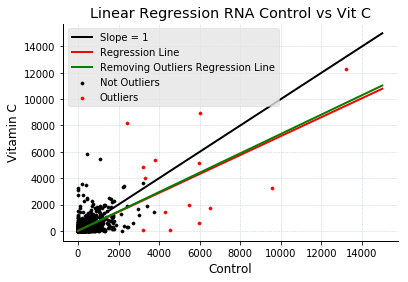

In [105]:
#outliers = ARPE_hMeDIP_outliers["cAMP_Average"].values
fig, tmp = plt.subplots()
ax = SC_cAMP_RNA_removing_outliers.plot.scatter(y = "cAMP_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = SC_cAMP_RNA_outliers["cAMP_Average"], x = SC_cAMP_RNA_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 15000, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression RNA Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model_RNA.params
x = sc.linspace(0, 15000, 10)
y = parameters[0] + parameters[1]*x


outlier_parameters = outliers_removed_model_RNA.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_cAMP_RNA_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()


I was surprised to find that removing the outliers Did almost nothing but a slight shift toward a slope of 1. The R2 values were low (~43% in the outliers removed model). I am not sure what to think, but I will remove the outliers.

In [106]:
print(len(SC_cAMP_RNA_removing_outliers))
print(len(SC_cAMP_RNA_first_RCPM_averages))
print(len(SC_cAMP_RNA_outliers))

# Difference of 14, which is the number of outliers

32869
32883
14


In [107]:
remove_outliers_RNA = SC_cAMP_Raw_RNA_data.drop(SC_cAMP_RNA_outliers.index, axis = 0)


In [108]:
total_counts_removing_outliers_RNA = remove_outliers_RNA.sum(axis=0)

In [109]:
total_counts_removing_outliers_RNA

SC_Control_01           2.507623e+07
SC_Control_02           3.351316e+07
SC_Control_03           3.202509e+07
SC_cAMP_01              3.427727e+07
SC_cAMP_02              3.376630e+07
SC_cAMP_03              3.328441e+07
Control_1_first_RCPM    9.203484e+05
Control_2_first_RCPM    9.243422e+05
Control_3_first_RCPM    9.230722e+05
cAMP_1_first_RCPM       9.427393e+05
cAMP_2_first_RCPM       9.419763e+05
cAMP_3_first_RCPM       9.415759e+05
Control_Average         9.225876e+05
cAMP_Average            9.420972e+05
dtype: float64

In [110]:
SC_cAMP_Raw_RNA_data.head()

,SC_Control_01,SC_Control_02,SC_Control_03,SC_cAMP_01,SC_cAMP_02,SC_cAMP_03,Control_1_first_RCPM,Control_2_first_RCPM,Control_3_first_RCPM,cAMP_1_first_RCPM,cAMP_2_first_RCPM,cAMP_3_first_RCPM,Control_Average,cAMP_Average
Gene_ID,,,,,,,,,,,,,,
ENSRNOG00000000001,70,91,93,91,60,79,2.569141,2.509913,2.680577,2.502804,1.673816,2.234815,2.586544,2.137145
ENSRNOG00000000007,2,2,2,1,0,0,0.073404,0.055163,0.057647,0.027503,0.000000,0.000000,0.062071,0.009168
ENSRNOG00000000008,16,20,18,5,3,4,0.587232,0.551629,0.518821,0.137517,0.083691,0.113155,0.552561,0.111454
ENSRNOG00000000009,2,4,2,4,2,6,0.073404,0.110326,0.057647,0.110013,0.055794,0.169733,0.080459,0.111847
ENSRNOG00000000010,76,90,79,0,1,0,2.789353,2.482332,2.277049,0.000000,0.027897,0.000000,2.516245,0.009299


In [111]:
SC_cAMP_Raw_RNA_data["SC_Control_1_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_01"]*1000000/total_counts_removing_outliers_RNA[0]
SC_cAMP_Raw_RNA_data["SC_Control_2_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_02"]*1000000/total_counts_removing_outliers_RNA[1]
SC_cAMP_Raw_RNA_data["SC_Control_3_RCPM"] = SC_cAMP_Raw_RNA_data["SC_Control_03"]*1000000/total_counts_removing_outliers_RNA[2]
SC_cAMP_Raw_RNA_data["SC_cAMP_1_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_01"]*1000000/total_counts_removing_outliers_RNA[3]
SC_cAMP_Raw_RNA_data["SC_cAMP_2_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_02"]*1000000/total_counts_removing_outliers_RNA[4]
SC_cAMP_Raw_RNA_data["SC_cAMP_3_RCPM"] = SC_cAMP_Raw_RNA_data["SC_cAMP_03"]*1000000/total_counts_removing_outliers_RNA[5]
SC_cAMP_RNA_Corrected_RCPM = SC_cAMP_Raw_RNA_data[["SC_Control_1_RCPM", "SC_Control_2_RCPM", "SC_Control_3_RCPM", "SC_cAMP_1_RCPM", "SC_cAMP_2_RCPM", "SC_cAMP_3_RCPM"]]

In [112]:
SC_cAMP_RNA_Corrected_RCPM.head()

,SC_Control_1_RCPM,SC_Control_2_RCPM,SC_Control_3_RCPM,SC_cAMP_1_RCPM,SC_cAMP_2_RCPM,SC_cAMP_3_RCPM
Gene_ID,,,,,,
ENSRNOG00000000001,2.791488,2.715351,2.903973,2.654820,1.776920,2.373483
ENSRNOG00000000007,0.079757,0.059678,0.062451,0.029174,0.000000,0.000000
ENSRNOG00000000008,0.638054,0.596780,0.562059,0.145869,0.088846,0.120176
ENSRNOG00000000009,0.079757,0.119356,0.062451,0.116695,0.059231,0.180265
ENSRNOG00000000010,3.030758,2.685512,2.466816,0.000000,0.029615,0.000000


In [113]:
SC_cAMP_RNA_Corrected_RCPM.to_csv(Output_Path+"SC_cAMP_RNA_RCPM_table.csv")

In [114]:
Rat_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )


In [115]:
Rat_Genomic_Info_File.dtypes # It looks like I don't need to specify the types because the lengths and positions went in as int

Gene_Name             object
Location              object
Sense                 object
Gene_Biotype          object
transcript_id         object
Chr                   object
Start                  int64
Stop                   int64
Length                 int64
Exon Length            int64
Intron Length          int64
Gene_ID               object
gene_version           int64
transcript_version     int64
gene_name             object
gene_source           object
gene_biotype          object
transcript_name       object
transcript_source     object
transcript_biotype    object
dtype: object

In [116]:
Rat_Genomic_Info_File.head()

,Gene_Name,Location,Sense,Gene_Biotype,transcript_id,Chr,Start,Stop,Length,Exon Length,Intron Length,Gene_ID,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Ensembl_ID,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,AABR07013255.1,chr2:230660664-230662084,+,pseudogene,ENSRNOT00000055633,2,230660664,230662084,1421,1416,5,ENSRNOG00000000001,5,2,AABR07013255.1,ensembl,pseudogene,AABR07013255.1-201,ensembl,pseudogene
ENSRNOG00000000007,Gad1,chr3:56861396-56902157,+,protein_coding,ENSRNOT00000087712,3,56862691,56902137,39447,3381,36066,ENSRNOG00000000007,7,1,Gad1,ensembl,protein_coding,Gad1-204,ensembl,protein_coding
ENSRNOG00000000008,Alx4,chr3:82548959-82585531,+,protein_coding,ENSRNOT00000000009,3,82548959,82585531,36573,1747,34826,ENSRNOG00000000008,7,5,Alx4,ensembl,protein_coding,Alx4-201,ensembl,protein_coding
ENSRNOG00000000009,Tmco5b,chr3:104749051-104765436,+,protein_coding,ENSRNOT00000000010,3,104749051,104765436,16386,1361,15025,ENSRNOG00000000009,5,5,Tmco5b,ensembl,protein_coding,Tmco5b-201,ensembl,protein_coding
ENSRNOG00000000010,Cbln1,chr19:20607507-20611316,+,protein_coding,ENSRNOT00000000011,19,20607507,20611316,3810,2444,1366,ENSRNOG00000000010,5,5,Cbln1,ensembl,protein_coding,Cbln1-201,ensembl,protein_coding


In [117]:
SC_cAMP_RNA_Corrected_RCPM = SC_cAMP_RNA_Corrected_RCPM.join(Rat_Genomic_Info_File)

In [118]:
SC_cAMP_RNA_Corrected_RCPM.head()

,SC_Control_1_RCPM,SC_Control_2_RCPM,SC_Control_3_RCPM,SC_cAMP_1_RCPM,SC_cAMP_2_RCPM,SC_cAMP_3_RCPM,Gene_Name,Location,Sense,Gene_Biotype,...,Intron Length,Gene_ID,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Gene_ID,,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,2.791488,2.715351,2.903973,2.654820,1.776920,2.373483,AABR07013255.1,chr2:230660664-230662084,+,pseudogene,...,5,ENSRNOG00000000001,5,2,AABR07013255.1,ensembl,pseudogene,AABR07013255.1-201,ensembl,pseudogene
ENSRNOG00000000007,0.079757,0.059678,0.062451,0.029174,0.000000,0.000000,Gad1,chr3:56861396-56902157,+,protein_coding,...,36066,ENSRNOG00000000007,7,1,Gad1,ensembl,protein_coding,Gad1-204,ensembl,protein_coding
ENSRNOG00000000008,0.638054,0.596780,0.562059,0.145869,0.088846,0.120176,Alx4,chr3:82548959-82585531,+,protein_coding,...,34826,ENSRNOG00000000008,7,5,Alx4,ensembl,protein_coding,Alx4-201,ensembl,protein_coding
ENSRNOG00000000009,0.079757,0.119356,0.062451,0.116695,0.059231,0.180265,Tmco5b,chr3:104749051-104765436,+,protein_coding,...,15025,ENSRNOG00000000009,5,5,Tmco5b,ensembl,protein_coding,Tmco5b-201,ensembl,protein_coding
ENSRNOG00000000010,3.030758,2.685512,2.466816,0.000000,0.029615,0.000000,Cbln1,chr19:20607507-20611316,+,protein_coding,...,1366,ENSRNOG00000000010,5,5,Cbln1,ensembl,protein_coding,Cbln1-201,ensembl,protein_coding


In [119]:
SC_cAMP_RNA_Corrected_RCPM["SC_Control_1_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_Control_1_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]
SC_cAMP_RNA_Corrected_RCPM["SC_Control_2_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_Control_2_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]
SC_cAMP_RNA_Corrected_RCPM["SC_Control_3_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_Control_3_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]

SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_1_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_1_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]
SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_2_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_2_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]
SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_3_FPKM"]= SC_cAMP_RNA_Corrected_RCPM["SC_cAMP_3_RCPM"]*1000/SC_cAMP_RNA_Corrected_RCPM["Exon Length"]


In [120]:
SC_cAMP_RNA_FPKM_table = SC_cAMP_RNA_Corrected_RCPM[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM", "SC_cAMP_1_FPKM", "SC_cAMP_2_FPKM", "SC_cAMP_3_FPKM"]]


In [121]:
SC_cAMP_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM
Gene_ID,,,,,,
ENSRNOG00000000001,1.971390,1.917621,2.050829,1.874873,1.254887,1.676189
ENSRNOG00000000007,0.023590,0.017651,0.018471,0.008629,0.000000,0.000000
ENSRNOG00000000008,0.365229,0.341603,0.321728,0.083497,0.050856,0.068790
ENSRNOG00000000009,0.058602,0.087697,0.045886,0.085742,0.043520,0.132450
ENSRNOG00000000010,1.240081,1.098818,1.009336,0.000000,0.012118,0.000000


In [122]:
#SC_cAMP_RNA_FPKM_table.to_csv(Output_Path+"SC_cAMP_RNA_FPKM_table.csv")
#SC_cAMP_RNA_FPKM_table.to_pickle(Output_Path+"SC_cAMP_RNA_FPKM_table.pkl")


Now I have the FPKM table for the RNA. Next I need to read in the statistical files (edgeR and DESeq2) and calculate fold changes to determine which direction each gene goes. When I did this for the hMeDIP, none of them had values of 0 so I didn't need to worry about dividing by infinity. For this one, I needed to make up a lambda function for an if statement if the values were below 0.1 for both cAMP and Control.

In [123]:
SC_cAMP_RNA_FPKM_table["Control_Average_FPKM"] = SC_cAMP_RNA_FPKM_table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_2_FPKM"]].mean(axis=1)
SC_cAMP_RNA_FPKM_table["cAMP_Average_FPKM"] = SC_cAMP_RNA_FPKM_table[["SC_cAMP_1_FPKM", "SC_cAMP_2_FPKM", "SC_cAMP_3_FPKM"]].mean(axis=1)
SC_cAMP_RNA_FPKM_table["Fold_Change"] =  SC_cAMP_RNA_FPKM_table.apply(lambda x: 1 if max(x["cAMP_Average_FPKM"],x["Control_Average_FPKM"]) < 0.1 else (x["cAMP_Average_FPKM"]/x["Control_Average_FPKM"]), axis = 1)


SC_cAMP_RNA_FPKM_table["Log2FC"] = np.log2(SC_cAMP_RNA_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3

In [124]:
SC_cAMP_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC
Gene_ID,,,,,,,,,,
ENSRNOG00000000001,1.971390,1.917621,2.050829,1.874873,1.254887,1.676189,1.935544,1.601983,0.827666,-0.272880
ENSRNOG00000000007,0.023590,0.017651,0.018471,0.008629,0.000000,0.000000,0.019631,0.002876,1.000000,0.000000
ENSRNOG00000000008,0.365229,0.341603,0.321728,0.083497,0.050856,0.068790,0.349478,0.067714,0.193759,-2.367666
ENSRNOG00000000009,0.058602,0.087697,0.045886,0.085742,0.043520,0.132450,0.077999,0.087237,1.000000,0.000000
ENSRNOG00000000010,1.240081,1.098818,1.009336,0.000000,0.012118,0.000000,1.145906,0.004039,0.003525,-8.148208


In [125]:
SC_cAMP_RNA_edgeR = pd.read_csv(Input_RNA_edgeR, sep = ",", index_col=0) 
SC_cAMP_RNA_edgeR = SC_cAMP_RNA_edgeR.drop(['logFC', 'logCPM', 'LR', 'PValue'], axis = 1)
SC_cAMP_RNA_edgeR.columns=["edgeR"]

SC_cAMP_RNA_DESeq2 = pd.read_csv(Input_RNA_DESeq2, sep = ",", index_col=0)
SC_cAMP_RNA_DESeq2 = SC_cAMP_RNA_DESeq2.drop(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue'], axis = 1)
SC_cAMP_RNA_DESeq2.columns = ["DESeq2"]
SC_cAMP_RNA_DESeq2 = SC_cAMP_RNA_DESeq2.fillna(1)

In [126]:
SC_cAMP_RNA_edgeR.head()

,edgeR
Gene_ID,
ENSRNOG00000015159,0.0
ENSRNOG00000001528,0.0
ENSRNOG00000029318,0.0
ENSRNOG00000013306,0.0
ENSRNOG00000015093,0.0


In [127]:
SC_cAMP_RNA_DESeq2.head()

,DESeq2
Gene_ID,
ENSRNOG00000001607,0.0
ENSRNOG00000001807,0.0
ENSRNOG00000002050,0.0
ENSRNOG00000002171,0.0
ENSRNOG00000002403,0.0


In [128]:
SC_cAMP_RNA_FPKM_table = SC_cAMP_RNA_FPKM_table.join([SC_cAMP_RNA_edgeR, SC_cAMP_RNA_DESeq2])

In [129]:
SC_cAMP_RNA_FPKM_table.head(15)

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2
Gene_ID,,,,,,,,,,,,
ENSRNOG00000000001,1.971390,1.917621,2.050829,1.874873,1.254887,1.676189,1.935544,1.601983,0.827666,-0.272880,3.624964e-01,2.684509e-01
ENSRNOG00000000007,0.023590,0.017651,0.018471,0.008629,0.000000,0.000000,0.019631,0.002876,1.000000,0.000000,9.810661e-02,2.310657e-01
ENSRNOG00000000008,0.365229,0.341603,0.321728,0.083497,0.050856,0.068790,0.349478,0.067714,0.193759,-2.367666,9.720000e-07,4.287680e-04
ENSRNOG00000000009,0.058602,0.087697,0.045886,0.085742,0.043520,0.132450,0.077999,0.087237,1.000000,0.000000,9.094232e-01,7.663421e-01
ENSRNOG00000000010,1.240081,1.098818,1.009336,0.000000,0.012118,0.000000,1.145906,0.004039,0.003525,-8.148208,2.150000e-47,3.630000e-15
ENSRNOG00000000012,0.000000,0.000000,0.000000,0.117518,0.149120,0.090768,0.000000,0.119135,inf,inf,4.112360e-04,2.591347e-02
ENSRNOG00000000017,2.492400,2.354485,2.439494,0.341881,0.439603,0.305135,2.400457,0.362206,0.150891,-2.728425,1.440000e-25,3.230000e-18
ENSRNOG00000000021,7.510432,5.942938,8.196699,5.470097,5.849027,5.332827,6.465436,5.550650,0.858511,-0.220091,5.583366e-02,2.977987e-02
ENSRNOG00000000024,10.213677,9.552982,8.703158,3.571187,4.378160,2.659270,9.773214,3.536206,0.361826,-1.466631,1.390000e-13,2.200000e-12


In [130]:
#SC_cAMP_RNA_FPKM_table.loc["ENSRNOG00000008000"] # This went in correctly

In [131]:
# This definition will mistakenly put "downregulated" for ones with good P-values by both but a fold change of 1
# These ones will be filtered out in the next step, finding limit of detection
def direction(row):
    if row["edgeR"] < 0.05 and row["DESeq2"] < 0.05:
        if row["Log2FC"] > 0:
            return "Upregulated"
        else:
            return "Downregulated"
    else:
        return "Nondifferential"

SC_cAMP_RNA_FPKM_table["Change"] =  SC_cAMP_RNA_FPKM_table.apply(direction, axis = 1)
# I figured out how to make it faster :)

In [132]:
SC_cAMP_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change
Gene_ID,,,,,,,,,,,,,
ENSRNOG00000000001,1.971390,1.917621,2.050829,1.874873,1.254887,1.676189,1.935544,1.601983,0.827666,-0.272880,3.624964e-01,2.684509e-01,Nondifferential
ENSRNOG00000000007,0.023590,0.017651,0.018471,0.008629,0.000000,0.000000,0.019631,0.002876,1.000000,0.000000,9.810661e-02,2.310657e-01,Nondifferential
ENSRNOG00000000008,0.365229,0.341603,0.321728,0.083497,0.050856,0.068790,0.349478,0.067714,0.193759,-2.367666,9.720000e-07,4.287680e-04,Downregulated
ENSRNOG00000000009,0.058602,0.087697,0.045886,0.085742,0.043520,0.132450,0.077999,0.087237,1.000000,0.000000,9.094232e-01,7.663421e-01,Nondifferential
ENSRNOG00000000010,1.240081,1.098818,1.009336,0.000000,0.012118,0.000000,1.145906,0.004039,0.003525,-8.148208,2.150000e-47,3.630000e-15,Downregulated


In [133]:
SC_cAMP_RNA_FPKM_table.to_csv(Output_Path+"SC_cAMP_RNA_FPKM_table.csv")
SC_cAMP_RNA_FPKM_table.to_pickle(Output_Path+"SC_cAMP_RNA_FPKM_table.pkl")

Now I have the FPKM table calculated out and I have determined which ones go up and down, but I have not filtered out genes that are really lowly expressed. The next step is to take those out because they will not add information to our analysis, but just add noise.

Now I am going to calculate the FPKM values for the genomic input samples. I am going to see if I can use these to determine a cutoff LOD for the RNA. Luckily, I don't need to worry about outliers for this one because it is genomic input and I want to include those ones if there is something funky because it might transfer across the other sequencing files too.

In [134]:
SC_cAMP_genomic_input_raw = pd.read_csv(Input_Genomic_Input_Counts_File, sep = "\t", index_col = 0)

In [135]:
SC_cAMP_genomic_input_raw.head()

,SC_Control_1_IN,SC_Control_2_IN,SC_Control_3_IN,SC_cAMP_1_IN,SC_cAMP_2_IN,SC_cAMP_3_IN
Peak_Name,,,,,,
Merged.cAMP_peak_100,27,39,26,13,26,27
Merged.cAMP_peak_10000,30,26,26,19,33,30
Merged.cAMP_peak_100003,34,39,43,19,28,38
Merged.cAMP_peak_100004,22,13,15,10,15,18
Merged.cAMP_peak_100007,17,23,25,12,17,16


In [136]:
total_counts_SC_cAMP_genomic_input = SC_cAMP_genomic_input_raw.sum(axis=0)

In [137]:
total_counts_SC_cAMP_genomic_input

SC_Control_1_IN    58705176
SC_Control_2_IN    80394782
SC_Control_3_IN    53895360
SC_cAMP_1_IN       56923555
SC_cAMP_2_IN       44195649
SC_cAMP_3_IN       60174118
dtype: int64

In [138]:
SC_cAMP_genomic_input_raw["SC_Control_1_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_Control_1_IN"]*1000000/total_counts_SC_cAMP_genomic_input[0]
SC_cAMP_genomic_input_raw["SC_Control_2_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_Control_2_IN"]*1000000/total_counts_SC_cAMP_genomic_input[1]
SC_cAMP_genomic_input_raw["SC_Control_3_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_Control_3_IN"]*1000000/total_counts_SC_cAMP_genomic_input[2]


SC_cAMP_genomic_input_raw["SC_cAMP_1_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_cAMP_1_IN"]*1000000/total_counts_SC_cAMP_genomic_input[3]
SC_cAMP_genomic_input_raw["SC_cAMP_2_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_cAMP_2_IN"]*1000000/total_counts_SC_cAMP_genomic_input[4]
SC_cAMP_genomic_input_raw["SC_cAMP_3_IN_RCPM"] = SC_cAMP_genomic_input_raw["SC_cAMP_3_IN"]*1000000/total_counts_SC_cAMP_genomic_input[5]


In [139]:
SC_cAMP_genomic_input_rcpm = SC_cAMP_genomic_input_raw[["SC_Control_1_IN_RCPM", "SC_Control_2_IN_RCPM", "SC_Control_3_IN_RCPM", "SC_cAMP_1_IN_RCPM", "SC_cAMP_2_IN_RCPM", "SC_cAMP_3_IN_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [140]:
SC_cAMP_genomic_input_rcpm.tail()


,SC_Control_1_IN_RCPM,SC_Control_2_IN_RCPM,SC_Control_3_IN_RCPM,SC_cAMP_1_IN_RCPM,SC_cAMP_2_IN_RCPM,SC_cAMP_3_IN_RCPM
Peak_Name,,,,,,
Merged.control_peak_99972,0.357720,0.199018,0.371089,0.281079,0.294147,0.232658
Merged.control_peak_99982,0.391788,0.335843,0.278317,0.281079,0.271520,0.432079
"Merged.control_peak_99992,Merged.cAMP_peak_89678",0.715439,0.385597,0.575189,0.527023,0.339400,0.498553
Merged.control_peak_99996,0.221446,0.223895,0.185545,0.281079,0.271520,0.265895
Merged.control_peak_99997,0.425857,0.348281,0.371089,0.368916,0.203640,0.282513


In [141]:
SC_cAMP_genomic_input_rcpm.to_csv(Output_Path+"SC_cAMP_Genomic_Input_RCPM_table.csv")

In [142]:
SC_cAMP_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3) 
SC_cAMP_hMeDIP_bed["Width"] = (SC_cAMP_hMeDIP_bed["Stop"] - SC_cAMP_hMeDIP_bed["Start"] + 1)

In [143]:
SC_cAMP_hMeDIP_bed.head()

,Chr,Start,Stop,Width
Peak_Name,,,,
Merged.cAMP_peak_100,1,1967917,1968676,760
Merged.cAMP_peak_10000,1,56166555,56167312,758
Merged.cAMP_peak_100003,13,50411889,50412871,983
Merged.cAMP_peak_100004,13,50421254,50421647,394
Merged.cAMP_peak_100007,13,50424220,50424677,458


In [144]:
SC_cAMP_genomic_input_rcpm = SC_cAMP_genomic_input_rcpm.join(SC_cAMP_hMeDIP_bed)

In [145]:
SC_cAMP_genomic_input_rcpm["SC_Control_1_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_Control_1_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]
SC_cAMP_genomic_input_rcpm["SC_Control_2_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_Control_2_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]
SC_cAMP_genomic_input_rcpm["SC_Control_3_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_Control_3_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]

SC_cAMP_genomic_input_rcpm["SC_cAMP_1_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_cAMP_1_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]
SC_cAMP_genomic_input_rcpm["SC_cAMP_2_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_cAMP_2_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]
SC_cAMP_genomic_input_rcpm["SC_cAMP_3_IN_FPKM"]= SC_cAMP_genomic_input_rcpm["SC_cAMP_3_IN_RCPM"]*1000/SC_cAMP_genomic_input_rcpm["Width"]


In [146]:
SC_cAMP_genomic_input_rcpm.head()

,SC_Control_1_IN_RCPM,SC_Control_2_IN_RCPM,SC_Control_3_IN_RCPM,SC_cAMP_1_IN_RCPM,SC_cAMP_2_IN_RCPM,SC_cAMP_3_IN_RCPM,Chr,Start,Stop,Width,SC_Control_1_IN_FPKM,SC_Control_2_IN_FPKM,SC_Control_3_IN_FPKM,SC_cAMP_1_IN_FPKM,SC_cAMP_2_IN_FPKM,SC_cAMP_3_IN_FPKM
Peak_Name,,,,,,,,,,,,,,,,
Merged.cAMP_peak_100,0.459925,0.485106,0.482416,0.228376,0.588293,0.448698,1,1967917,1968676,760,0.605165,0.638298,0.634758,0.300495,0.774070,0.590392
Merged.cAMP_peak_10000,0.511028,0.323404,0.482416,0.333781,0.746680,0.498553,1,56166555,56167312,758,0.674180,0.426654,0.636433,0.440344,0.985066,0.657722
Merged.cAMP_peak_100003,0.579165,0.485106,0.797842,0.333781,0.633547,0.631501,13,50411889,50412871,983,0.589181,0.493496,0.811640,0.339553,0.644503,0.642422
Merged.cAMP_peak_100004,0.374754,0.161702,0.278317,0.175674,0.339400,0.299132,13,50421254,50421647,394,0.951152,0.410411,0.706389,0.445874,0.861421,0.759218
Merged.cAMP_peak_100007,0.289583,0.286088,0.463862,0.210809,0.384653,0.265895,13,50424220,50424677,458,0.632277,0.624647,1.012799,0.460282,0.839854,0.580557


In [147]:
SC_cAMP_genomic_input_rcpm.describe()

,SC_Control_1_IN_RCPM,SC_Control_2_IN_RCPM,SC_Control_3_IN_RCPM,SC_cAMP_1_IN_RCPM,SC_cAMP_2_IN_RCPM,SC_cAMP_3_IN_RCPM,Start,Stop,Width,SC_Control_1_IN_FPKM,SC_Control_2_IN_FPKM,SC_Control_3_IN_FPKM,SC_cAMP_1_IN_FPKM,SC_cAMP_2_IN_FPKM,SC_cAMP_3_IN_FPKM
count,192143.000000,192143.000000,192143.000000,192143.000000,192143.000000,192143.000000,1.921430e+05,1.921430e+05,192143.000000,192143.000000,192143.000000,192143.000000,192143.000000,192143.000000,192143.000000
mean,0.391461,0.351875,0.446925,0.365266,0.447664,0.419764,8.154366e+07,8.154434e+07,678.019090,0.582181,0.526776,0.654762,0.554516,0.649120,0.619863
std,0.234153,0.200337,0.291197,0.204772,0.325828,0.260089,6.153130e+07,6.153131e+07,382.118276,0.168268,0.135139,0.213077,0.174750,0.265976,0.188589
min,0.000000,0.012439,0.000000,0.000000,0.000000,0.000000,1.800000e+01,4.820000e+02,265.000000,0.000000,0.035539,0.000000,0.000000,0.000000,0.000000
25%,0.238480,0.223895,0.259763,0.228376,0.226267,0.249277,3.381977e+07,3.382040e+07,434.000000,0.474115,0.441022,0.516838,0.437969,0.460850,0.500555
50%,0.340685,0.298527,0.371089,0.316214,0.362027,0.365606,6.849322e+07,6.849430e+07,555.000000,0.570867,0.517198,0.646671,0.533501,0.625360,0.611381
75%,0.476960,0.422913,0.556634,0.439186,0.565667,0.515172,1.149180e+08,1.149185e+08,790.000000,0.677095,0.602598,0.779115,0.651334,0.809541,0.728879
max,7.648389,7.848768,9.908089,7.553991,8.847025,8.857629,2.825998e+08,2.826003e+08,16749.000000,6.962237,5.083904,9.706972,6.701468,8.939689,8.377143


In [148]:
SC_cAMP_Genomic_Input_FPKM_table = SC_cAMP_genomic_input_rcpm[["SC_Control_1_IN_FPKM", "SC_Control_2_IN_FPKM", "SC_Control_3_IN_FPKM", 
                                                               "SC_cAMP_1_IN_FPKM", "SC_cAMP_2_IN_FPKM", "SC_cAMP_3_IN_FPKM"]]
SC_cAMP_Genomic_Input_FPKM_table.to_csv(Output_Path+"SC_cAMP_Genomic_Input_FPKM_table.csv")
#I am not going to make a pickle file for this one because I don't think we are likely to use it in future analysis

Well, calculating the FPKM for the genomic input without removing outliers was much less painful. Now I can move on to a density plot with genomic input (should have no bias to any region) and RNA. 

The genomic input is just sheared DNA with no form of pull-down. This is meant to show us what kind of coverage you get in each genomic region just by chance of the DNA-sequence. These were generated for calling peaks in the hMeDIP, but can be used her to show what we get if we are just sequencing noise. 

I am going to look at a density plot of the genomic input samples. These are just noise, so if we use a cutoff for limit of detection below the top expressed of these, those ones would essentially be "false positives" as to limit of detection.

When I look at the denisty plot for the RNA, those are annotated genes. In other words, those should be annotated as "above limit of detection", so if I use a cutoff above the most lowly expressed gene, this gives "false negatives" as to the limit of detection. 

I am going to chart both the genomic input samples and the RNA samples on the same graph. Where the two overlap, there will be a minimum between the "false positives" and the "false negatives". This value gives us our limit of detection. (See Trapnell et al. 2012 Nature Protocols)



First I need to take the log10 of each value. It makes it easier to visualize. 

In [149]:

SC_cAMP_Genomic_Input_FPKM_table = pd.read_csv(Output_Path+"SC_cAMP_Genomic_Input_FPKM_table.csv", sep = ",", index_col = 0)
SC_cAMP_RNA_FPKM_table = pd.read_pickle(Output_Path+"SC_cAMP_RNA_FPKM_table.pkl")


In [150]:
SC_cAMP_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change
Gene_ID,,,,,,,,,,,,,
ENSRNOG00000000001,1.971390,1.917621,2.050829,1.874873,1.254887,1.676189,1.935544,1.601983,0.827666,-0.272880,3.624964e-01,2.684509e-01,Nondifferential
ENSRNOG00000000007,0.023590,0.017651,0.018471,0.008629,0.000000,0.000000,0.019631,0.002876,1.000000,0.000000,9.810661e-02,2.310657e-01,Nondifferential
ENSRNOG00000000008,0.365229,0.341603,0.321728,0.083497,0.050856,0.068790,0.349478,0.067714,0.193759,-2.367666,9.720000e-07,4.287680e-04,Downregulated
ENSRNOG00000000009,0.058602,0.087697,0.045886,0.085742,0.043520,0.132450,0.077999,0.087237,1.000000,0.000000,9.094232e-01,7.663421e-01,Nondifferential
ENSRNOG00000000010,1.240081,1.098818,1.009336,0.000000,0.012118,0.000000,1.145906,0.004039,0.003525,-8.148208,2.150000e-47,3.630000e-15,Downregulated


In [151]:
control_1_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_Control_1_FPKM"].values:
    if i > 0.001:
        control_1_RNA.append(np.log10(i))

control_2_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_Control_2_FPKM"].values:
    if i > 0.001:
        control_2_RNA.append(np.log10(i))

control_3_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_Control_3_FPKM"].values:
    if i > 0.001:
        control_3_RNA.append(np.log10(i))

cAMP_1_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_cAMP_1_FPKM"].values:
    if i > 0.001:
        cAMP_1_RNA.append(np.log10(i))

cAMP_2_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_cAMP_2_FPKM"].values:
    if i > 0.001:
        cAMP_2_RNA.append(np.log10(i))

cAMP_3_RNA = []
for i in SC_cAMP_RNA_FPKM_table["SC_cAMP_3_FPKM"].values:
    if i > 0.001:
        cAMP_3_RNA.append(np.log10(i))
        


control_1_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_Control_1_IN_FPKM"].values:
    if i > 0.001:
        control_1_INPUT.append(np.log10(i))
        
control_2_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_Control_2_IN_FPKM"].values:
    if i > 0.001:
        control_2_INPUT.append(np.log10(i))
        
control_3_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_Control_3_IN_FPKM"].values:
    if i > 0.001:
        control_3_INPUT.append(np.log10(i))
        
        
cAMP_1_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_cAMP_1_IN_FPKM"].values:
    if i > 0.001:
        cAMP_1_INPUT.append(np.log10(i))
        
cAMP_2_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_cAMP_2_IN_FPKM"].values:
    if i > 0.001:
        cAMP_2_INPUT.append(np.log10(i))

cAMP_3_INPUT = []
for i in SC_cAMP_Genomic_Input_FPKM_table["SC_cAMP_3_IN_FPKM"].values:
    if i > 0.001:
        cAMP_3_INPUT.append(np.log10(i))
        

In [152]:
print(len(control_1_RNA))
print(len(control_2_RNA))
print(len(control_3_RNA))
print(len(cAMP_1_RNA))
print(len(cAMP_2_RNA))
print(len(cAMP_3_RNA))
print(len(control_1_INPUT))
print(len(control_2_INPUT))
print(len(control_3_INPUT))
print(len(cAMP_1_INPUT))
print(len(cAMP_2_INPUT))
print(len(cAMP_3_INPUT))
# The lengths are not identical for any of them indicating I didn't accidentally copy over any of them

18326
18864
19348
18189
18333
18247
192136
192143
192129
192137
192071
192131


In [153]:
import itertools

In [154]:
log_tables_list = [control_1_RNA, control_2_RNA, control_3_RNA, cAMP_1_RNA, cAMP_2_RNA, cAMP_3_RNA,
                   control_1_INPUT, control_2_INPUT, control_3_INPUT, cAMP_1_INPUT, cAMP_2_INPUT, cAMP_3_INPUT]
table_of_logs = pd.DataFrame((_ for _ in itertools.zip_longest(*log_tables_list)), columns=["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                                                                                                "cAMP_1_RNA", "cAMP_2_RNA", "cAMP_3_RNA", 
                                                                                                "control_1_INPUT", "control_2_INPUT", "control_3_INPUT",
                                                                                            "cAMP_1_INPUT", "cAMP_2_INPUT", "cAMP_3_INPUT"])

In [155]:
table_of_logs.head()

,control_1_RNA,control_2_RNA,control_3_RNA,cAMP_1_RNA,cAMP_2_RNA,cAMP_3_RNA,control_1_INPUT,control_2_INPUT,control_3_INPUT,cAMP_1_INPUT,cAMP_2_INPUT,cAMP_3_INPUT
0,0.294773,0.282763,0.311929,0.272972,0.098605,0.224323,-0.218126,-0.194977,-0.197392,-0.522162,-0.111220,-0.228860
1,-1.627277,-1.753231,-1.733505,-2.064051,-1.293655,-1.162474,-0.171224,-0.369924,-0.196247,-0.356208,-0.006535,-0.181958
2,-0.437435,-0.466478,-0.492511,-1.078329,-1.361312,-0.877948,-0.229751,-0.306717,-0.090636,-0.469092,-0.190775,-0.192180
3,-1.232090,-1.057014,-1.338318,-1.066804,-1.916585,-1.042069,-0.021750,-0.386781,-0.150956,-0.350788,-0.064784,-0.119633
4,0.093450,0.040926,0.004036,-0.929896,-0.826463,-0.515508,-0.199093,-0.204366,0.005523,-0.336976,-0.075796,-0.236155


In [156]:
import seaborn as sns

/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


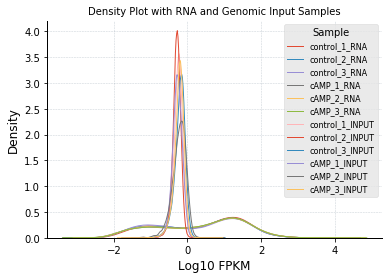

In [157]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                "cAMP_1_RNA", "cAMP_2_RNA", "cAMP_3_RNA", 
                "control_1_INPUT", "control_2_INPUT", "control_3_INPUT", 
                "cAMP_1_INPUT", "cAMP_2_INPUT", "cAMP_3_INPUT"]

fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_cAMP_RNA_LOD_Chart.png", dpi=300) # size above specified at 10x6


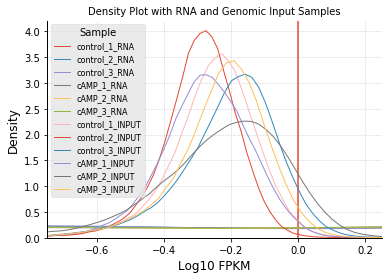

In [158]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                "cAMP_1_RNA", "cAMP_2_RNA", "cAMP_3_RNA", 
                "control_1_INPUT", "control_2_INPUT", "control_3_INPUT", 
                "cAMP_1_INPUT", "cAMP_2_INPUT", "cAMP_3_INPUT"]


fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=0)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_cAMP_RNA_LOD_Chart_Zoomed.png", dpi=300) # size above specified at 10x6

From the graphs above, we can see that they cross at about 0. This is log base 10, so this converts to 1 FPKM. I am going to use 1 as my limit of detection for simplicity. Moving forward, I am going to keep genes that have one or both sample types averages above 1 FPKM. These are the ones that will be used for further analysis.

In [159]:
SC_cAMP_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change
Gene_ID,,,,,,,,,,,,,
ENSRNOG00000000001,1.971390,1.917621,2.050829,1.874873,1.254887,1.676189,1.935544,1.601983,0.827666,-0.272880,3.624964e-01,2.684509e-01,Nondifferential
ENSRNOG00000000007,0.023590,0.017651,0.018471,0.008629,0.000000,0.000000,0.019631,0.002876,1.000000,0.000000,9.810661e-02,2.310657e-01,Nondifferential
ENSRNOG00000000008,0.365229,0.341603,0.321728,0.083497,0.050856,0.068790,0.349478,0.067714,0.193759,-2.367666,9.720000e-07,4.287680e-04,Downregulated
ENSRNOG00000000009,0.058602,0.087697,0.045886,0.085742,0.043520,0.132450,0.077999,0.087237,1.000000,0.000000,9.094232e-01,7.663421e-01,Nondifferential
ENSRNOG00000000010,1.240081,1.098818,1.009336,0.000000,0.012118,0.000000,1.145906,0.004039,0.003525,-8.148208,2.150000e-47,3.630000e-15,Downregulated


In [160]:
SC_cAMP_RNA_FPKM_table["Expressed"] = SC_cAMP_RNA_FPKM_table.apply(lambda x: ("Expressed") if (x["cAMP_Average_FPKM"] > 1 or x["Control_Average_FPKM"] > 1) else "Below_LOD", axis = 1)

In [161]:
SC_cAMP_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_cAMP_1_FPKM,SC_cAMP_2_FPKM,SC_cAMP_3_FPKM,Control_Average_FPKM,cAMP_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change,Expressed
Gene_ID,,,,,,,,,,,,,,
ENSRNOG00000000001,1.971390,1.917621,2.050829,1.874873,1.254887,1.676189,1.935544,1.601983,0.827666,-0.272880,3.624964e-01,2.684509e-01,Nondifferential,Expressed
ENSRNOG00000000007,0.023590,0.017651,0.018471,0.008629,0.000000,0.000000,0.019631,0.002876,1.000000,0.000000,9.810661e-02,2.310657e-01,Nondifferential,Below_LOD
ENSRNOG00000000008,0.365229,0.341603,0.321728,0.083497,0.050856,0.068790,0.349478,0.067714,0.193759,-2.367666,9.720000e-07,4.287680e-04,Downregulated,Below_LOD
ENSRNOG00000000009,0.058602,0.087697,0.045886,0.085742,0.043520,0.132450,0.077999,0.087237,1.000000,0.000000,9.094232e-01,7.663421e-01,Nondifferential,Below_LOD
ENSRNOG00000000010,1.240081,1.098818,1.009336,0.000000,0.012118,0.000000,1.145906,0.004039,0.003525,-8.148208,2.150000e-47,3.630000e-15,Downregulated,Expressed


In [162]:
SC_cAMP_Expressed_Genes = SC_cAMP_RNA_FPKM_table[SC_cAMP_RNA_FPKM_table["Expressed"] == "Expressed"]

In [163]:
len(SC_cAMP_Expressed_Genes)
# We have 12,165 genes left that are expressed

12165

I am a little bummed to see that we only have 12,165 genes left, but this matches what I got with the other Rat cell dataset. I think we have more that are really detectable, but this matches the other one. Additionally, the two hump minimum method (below) matches around 0. I think it is fine. 


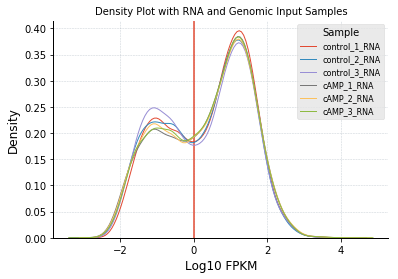

In [164]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "cAMP_1_RNA", "cAMP_2_RNA", "cAMP_3_RNA"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
#ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=0)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_cAMP_RNA_LOD_using_RNA_only.png", dpi=300) # size above specified at 10x6

If I change the line to -0.15, it changes the LOD to only 0.71, which I think is more reasonable. I am going to try that. 

In [165]:
print("Downregulated Genes:", len(SC_cAMP_Expressed_Genes[SC_cAMP_Expressed_Genes["Change"] == "Downregulated"]))
print("Upregulated Genes:",len(SC_cAMP_Expressed_Genes[SC_cAMP_Expressed_Genes["Change"] == "Upregulated"]))
print("Nondifferential Genes:",len(SC_cAMP_Expressed_Genes[SC_cAMP_Expressed_Genes["Change"] == "Nondifferential"]))

Downregulated Genes: 3867
Upregulated Genes: 4345
Nondifferential Genes: 3953


In [166]:
SC_cAMP_Expressed_Genes.to_csv(Output_Path+"SC_cAMP_Expressed_RNA.csv")
SC_cAMP_Expressed_Genes.to_pickle(Output_Path+"SC_cAMP_Expressed_RNA.pkl")

We can see that we have 1,984 genes that go up and 1,798 genes that go down after treatement with vitamin C. This is much lower than the 8,370 genes that do not change after treatment. This matches the assumption that most genes will not change, and indicates that our treatment was not too extreme.

Now I have a table of the expressed genes, as well as the information about how they react to vitamin C treatment.
The next step is going to be to integrate this with the information that we have generated about the hMeDIP peaks.

In [167]:
SC_cAMP_Expressed_Genes = pd.read_pickle(Output_Path+"SC_cAMP_Expressed_RNA.pkl")
Rat_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )
summed_counts = pd.read_pickle(Output_Path+"SC_cAMP_Counts_of_peaks_per_region.pkl")

In [168]:
Rat_Genomic_Info_File.head()

,Gene_Name,Location,Sense,Gene_Biotype,transcript_id,Chr,Start,Stop,Length,Exon Length,Intron Length,Gene_ID,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Ensembl_ID,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,AABR07013255.1,chr2:230660664-230662084,+,pseudogene,ENSRNOT00000055633,2,230660664,230662084,1421,1416,5,ENSRNOG00000000001,5,2,AABR07013255.1,ensembl,pseudogene,AABR07013255.1-201,ensembl,pseudogene
ENSRNOG00000000007,Gad1,chr3:56861396-56902157,+,protein_coding,ENSRNOT00000087712,3,56862691,56902137,39447,3381,36066,ENSRNOG00000000007,7,1,Gad1,ensembl,protein_coding,Gad1-204,ensembl,protein_coding
ENSRNOG00000000008,Alx4,chr3:82548959-82585531,+,protein_coding,ENSRNOT00000000009,3,82548959,82585531,36573,1747,34826,ENSRNOG00000000008,7,5,Alx4,ensembl,protein_coding,Alx4-201,ensembl,protein_coding
ENSRNOG00000000009,Tmco5b,chr3:104749051-104765436,+,protein_coding,ENSRNOT00000000010,3,104749051,104765436,16386,1361,15025,ENSRNOG00000000009,5,5,Tmco5b,ensembl,protein_coding,Tmco5b-201,ensembl,protein_coding
ENSRNOG00000000010,Cbln1,chr19:20607507-20611316,+,protein_coding,ENSRNOT00000000011,19,20607507,20611316,3810,2444,1366,ENSRNOG00000000010,5,5,Cbln1,ensembl,protein_coding,Cbln1-201,ensembl,protein_coding


In [169]:
labels = SC_cAMP_Expressed_Genes[["Change"]]
relevant_genomic_info = Rat_Genomic_Info_File[["Gene_Name", "Gene_Biotype", "Chr", "Length", "Exon Length"]]

In [170]:
labels.head()

,Change
Gene_ID,
ENSRNOG00000000001,Nondifferential
ENSRNOG00000000010,Downregulated
ENSRNOG00000000017,Downregulated
ENSRNOG00000000021,Nondifferential
ENSRNOG00000000024,Downregulated


In [171]:
relevant_genomic_info.head()

,Gene_Name,Gene_Biotype,Chr,Length,Exon Length
Ensembl_ID,,,,,
ENSRNOG00000000001,AABR07013255.1,pseudogene,2,1421,1416
ENSRNOG00000000007,Gad1,protein_coding,3,39447,3381
ENSRNOG00000000008,Alx4,protein_coding,3,36573,1747
ENSRNOG00000000009,Tmco5b,protein_coding,3,16386,1361
ENSRNOG00000000010,Cbln1,protein_coding,19,3810,2444


In [172]:
expressed_genes_info = labels.join(relevant_genomic_info)

In [173]:
expressed_genes_info.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon Length
Gene_ID,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416
ENSRNOG00000000010,Downregulated,Cbln1,protein_coding,19,3810,2444
ENSRNOG00000000017,Downregulated,Steap1,protein_coding,4,10589,1280
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200
ENSRNOG00000000024,Downregulated,Hebp1,protein_coding,4,29515,1062


In [174]:
expressed_genes_info.groupby(["Gene_Biotype"], as_index = False).size()

Gene_Biotype
0                                      45
Mt_rRNA                                 2
Mt_tRNA                                 7
TEC                                     3
antisense_RNA                          20
lincRNA                               232
miRNA                                  84
misc_RNA                               36
processed_pseudogene                  116
processed_transcript                   38
protein_coding                      11197
pseudogene                            153
rRNA                                    3
ribozyme                                2
scaRNA                                  4
snRNA                                 116
snoRNA                                 96
transcribed_processed_pseudogene        4
unprocessed_pseudogene                  7
dtype: int64

It is not surprising that the majority of the expressed genes (11,197 of the 12,165) are protein coding genes. It looks like the next most common is lincRNA (232) and processed_pseudogenes (116) and snRNA (116). I may join all of the noncoding types together for further anaylsis.

In [175]:
expressed_genes_info.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon Length
Gene_ID,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416
ENSRNOG00000000010,Downregulated,Cbln1,protein_coding,19,3810,2444
ENSRNOG00000000017,Downregulated,Steap1,protein_coding,4,10589,1280
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200
ENSRNOG00000000024,Downregulated,Hebp1,protein_coding,4,29515,1062


In [176]:
summed_counts.index.names = ["Gene_ID"]
summed_counts.head()

,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated
Gene_ID,,,,,,,,,,,,
ENSRNOG00000000007,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000024,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000033,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0


In [177]:
expressed_genes_info = expressed_genes_info.join(summed_counts) #, left_index=True, right_index=True
expressed_genes_info = expressed_genes_info.fillna(0)

In [178]:
expressed_genes_info.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated
Gene_ID,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000010,Downregulated,Cbln1,protein_coding,19,3810,2444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000017,Downregulated,Steap1,protein_coding,4,10589,1280,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000024,Downregulated,Hebp1,protein_coding,4,29515,1062,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [179]:
expressed_genes_info.describe()

,Length,Exon Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated
count,1.216500e+04,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000
mean,4.467486e+04,2601.714838,0.667078,0.057460,0.038224,0.002877,1.263872,0.086478,0.067900,0.006905,2.662145,0.119605,0.129634,0.016194
std,8.133324e+04,1942.513951,1.905177,0.238658,0.197240,0.053564,2.915743,0.298112,0.263085,0.082813,5.709072,0.365723,0.375439,0.126876
min,4.900000e+01,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.639000e+03,1338.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.947800e+04,2160.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,4.897200e+04,3406.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
max,2.232523e+06,23724.000000,43.000000,2.000000,2.000000,1.000000,69.000000,4.000000,2.000000,1.000000,74.000000,6.000000,5.000000,2.000000


In [180]:
expressed_genes_info.to_csv("Output_Tables_and_Results/SC_cAMP_Combined_Cleaned_Data.csv")
expressed_genes_info.to_pickle("Output_Tables_and_Results/SC_cAMP_Combined_Cleaned_Data.pkl")


In [181]:
expressed_genes_info[["Change"]].describe()
expressed_genes_info.groupby("Change").count()

,Gene_Name,Gene_Biotype,Chr,Length,Exon Length,Gene_Body_Downregulated,Upstream_Promoter_Downregulated,Downstream_Promoter_Downregulated,TSS_Downregulated,Gene_Body_Nondifferential,Upstream_Promoter_Nondifferential,Downstream_Promoter_Nondifferential,TSS_Nondifferential,Gene_Body_Upregulated,Upstream_Promoter_Upregulated,Downstream_Promoter_Upregulated,TSS_Upregulated
Change,,,,,,,,,,,,,,,,,
Downregulated,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867
Nondifferential,3953,3953,3953,3953,3953,3953,3953,3953,3953,3953,3953,3953,3953,3953,3953,3953,3953
Upregulated,4345,4345,4345,4345,4345,4345,4345,4345,4345,4345,4345,4345,4345,4345,4345,4345,4345


This is the finally cleaned data. I realize that I did not need to have all of the steps for finding outliers to get the table this way, but it was needed to accurately determine the fold change, which might end up being used in this project and will very likely be used in other projects. Additionally, the corrected FPKM values are needed for heatmaps and were needed to determine the expression threshold. 

Exploration of the data has shown that there are slightly more upregulated genes than downregulated genes in the SC cAMP dataset, and there are approximately equal number of nondifferential genes as downregulated. This is probably because cAMP changes not only DNA methylation, but changes the methylation of three different transcription factors and makes them become active. 
About 90% of the expressed genes are protein coding genes (11,197), even though they make up a relatively small portion of the annotated genome. This is consistent with other RNA-seq studies in Rat, and there are probably more noncoding genes, but they aren't as well annotated in rats. It looks like the highest average peak counts are genebody upregulated (2.66) followed by genebody nondifferential (1.26). We now have many dimensions and this should be helpful for determining if we can classify genes based on the genomic info and hMeDIP peak information (data about DNA methylation). 